In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import time
import math
import random
import copy
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import keras
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import datasets, layers, models
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from keras.utils.np_utils import to_categorical
from sklearn.cluster import KMeans, AgglomerativeClustering
from tensorflow.keras.datasets import cifar10 
from sklearn.metrics import silhouette_samples, silhouette_score

mod = sys.modules[__name__]

In [2]:
def distribution_check(dataset):
        #분포가 다름;
    one,two,three,four,five,six,seven,eight,nine,ten=0,0,0,0,0,0,0,0,0,0

    for i in range(len(dataset)):
        if(dataset[i]==1):    one+=1
        elif(dataset[i]==2):  two+=1
        elif(dataset[i]==3):  three+=1
        elif(dataset[i]==4):  four+=1
        elif(dataset[i]==5):  five+=1
        elif(dataset[i]==6):  six+=1
        elif(dataset[i]==7):  seven+=1
        elif(dataset[i]==8):  eight+=1
        elif(dataset[i]==9):  nine+=1
        elif(dataset[i]==0):  ten+=1

    #print(one,two,three,four,five,six,seven,eight,nine,ten)
    #print("Sum : ", one+two+three+four+five+six+seven+eight+nine+ten)
    sums = one+two+three+four+five+six+seven+eight+nine+ten
    for_graph=[one,two,three,four,five,six,seven,eight,nine,ten]
    
    return for_graph, sums

def local_model_generate(model): #초기 모델 생성
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    
    return model

def step_function(data):
    if data > 0:
        return 1
    else:
        return 0

def sigmoid(data):
    return 1/(1+np.exp(-data))

def relu(data):
    return np.maximum(0,data)

def random_check(local, train_data, test_data):
    check_distribution_train_data, check_distribution_test_data, y_train_tmp, y_test_tmp = [], [], [], []
    sum1, sum2, data_index = 0,0, np.arange(0,10)

    for j in range(len(train_data)):
        y_train_tmp.append(np.argmax(train_data[j])) #원핫인코딩에서 다시 0~9 레이블로 변환

    for j in range(len(test_data)):
        y_test_tmp.append(np.argmax(test_data[j]))

    check_distribution_train_data, sum_train = distribution_check(y_train_tmp) #한번 밖에 실행 못함
    check_distribution_test_data, sum_test = distribution_check(y_test_tmp)
    sum1, sum2 = (sum1 + sum_train), (sum2 + sum_test)
    
    return check_distribution_train_data, check_distribution_test_data


In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(x_train.shape, x_test.shape)
num_train, num_test = len(x_train),  len(x_test) 

170500096/170498071 [==============================] - 3s 0us/step
(50000, 32, 32, 3) (10000, 32, 32, 3)


In [4]:
batch_size, epochs = 32, 10
global_epoch = 0
num_layers = 8

In [5]:
# Model / data parameters
num_classes = 10
input_shape = (32, 32, 3)

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

print("Step 1 x_train shape:", x_train.shape)

#x_train = x_train.reshape((num_train, 28, 28, 1))
#x_test = x_test.reshape((num_test, 28, 28, 1))

print("Step 2 x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")
# convert class vectors to binary class matrices => one hot encoding 지금은 [3,6,2,5,4,8..] 섞여있음 

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Step 1 x_train shape: (50000, 32, 32, 3)
Step 2 x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [6]:
#랜덤 비복원추출, 동등하게 10% 씩 =  로컬 데이터 추출 ------------------------------------------------------------------------------

global_epoch = 0
local = 21

print(global_epoch, " 번째 global_epoch 데이터 랜덤하게 준비!!")

for i in range(1,local): #데이터 변수 선언, 빈 리스트로 초기화
    globals()['L{}_x_train'.format(i)], globals()['L{}_x_test'.format(i)] = [], []  
    globals()['L{}_y_train'.format(i)], globals()['L{}_y_test'.format(i)] = [], []  

x_train_range = list(np.arange(0,len(x_train)))  #0~59,999
x_test_range = list(np.arange(0,len(x_test)))  #0~9,999

for n in range(1,local): #Data_x_train_range, 잘 작동함 => 확인 완료
    tmp, tmp2 = [], []
    tmp = random.sample(list(x_train_range), int(num_train/(local-1)))  #1/10개 만큼 인덱스 랜덤 비복원 추출 => 랜덤으로 해야함
    tmp2 = random.sample(list(x_test_range), int(num_test/(local-1)))

    for i in range(len(tmp)):
        globals()['L{}_x_train'.format(n)].append(x_train[tmp[i]])  #n번째 Cluster에 분할한 실제 x_train 데이터 저장
        globals()['L{}_y_train'.format(n)].append(y_train[tmp[i]]) 
        #x_train_range.remove(tmp[i])  #랜덤 하게 뽑힌 원소 6000개 추출했으니 안에서 삭제 => 비복원 추출

    for j in range(len(tmp2)):
        globals()['L{}_x_test'.format(n)].append(x_test[tmp2[j]])
        globals()['L{}_y_test'.format(n)].append(y_test[tmp2[j]])
        #x_test_range.remove(tmp2[j])  #랜덤 하게 뽑힌 원소 6000개 추출했으니 안에서 삭제 => 비복원 추출

print("check=>: should be 0 == ", len(x_train_range))  #원소 하나도 없어야 함. 확인.

print(global_epoch, " 번째 global_epoch 데이터 랜덤 준비완료!!")

0  번째 global_epoch 데이터 랜덤하게 준비!!
check=>: should be 0 ==  50000
0  번째 global_epoch 데이터 랜덤 준비완료!!


In [7]:
#준비된 데이터 (IID / NON-IID) np.array로

best_Sil_score_c = []
Silhouette_sc_c = []

global_epoch = 0
acc, loss = 0, 0
cluster_acc, cluster_loss, Cluster_ACC, Cluster_LOSS = [], [], [], [] 
num_layers_list = [0,2,4,6,7]
label_list = []
VAR_final_list_w, VAR_final_list_b = [], []


for i in range(1,local):
    globals()['L{}_x_train'.format(i)] = np.array(globals()['L{}_x_train'.format(i)])
    globals()['L{}_x_test'.format(i)] = np.array(globals()['L{}_x_test'.format(i)])
    globals()['L{}_y_train'.format(i)] = np.array(globals()['L{}_y_train'.format(i)])
    globals()['L{}_y_test'.format(i)] = np.array(globals()['L{}_y_test'.format(i)])


print("\n\n",global_epoch, "번째 global epoch에서 로컬 클라이언트 학습시작!\n\n학습 중 ...\n")
now = time.time()

for i in range(1,local):
    globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)] = models.Sequential()  ##!!!!!!! 이게 글로벌 epoch에서는 2번째 부터 들어가면 안됨
    globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)] = local_model_generate(globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)])      # initialize 필요 => 모델 프레임 구축

    globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].fit(globals()['L{}_x_train'.format(i)], globals()['L{}_y_train'.format(i)], batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=0)

    loss, acc = globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].evaluate(globals()['L{}_x_test'.format(i,global_epoch)], globals()['L{}_y_test'.format(i)], verbose=2)
    
    cluster_acc.append(acc)  #acc 넣기
    cluster_loss.append(loss)  #loss 넣기


print(global_epoch, "번째 global epoch 로컬 클라이언트 학습완료!,  Total Training time : ", time.time()-now,"\n\n")

# 로컬 모델들 학습 완료하였고 로컬모델에서 weight, bias 추출 -------------------------------------------------------------------------------------

for i in range(1, local):
    for layer_index in num_layers_list:
        w = globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].layers[layer_index].get_weights() #get_weights = w[0],b[1]로 구성

        globals()['L{}_layer{}_w_tmp'.format(i,layer_index)] = w      # 클러스터링 용도
        globals()['L{}_layer{}_w'.format(i,layer_index)] = w          # weight aggregation 용도
            
# 클러스터에 넣을 변수 선언

for layer_index in num_layers_list:

    globals()['layer{}_W_tmp'.format(layer_index)] = []
    globals()['var_list_layer{}_w'.format(layer_index)] = []
    globals()['var_list_layer{}_b'.format(layer_index)] = []
  
    for i in range(1, local):
        globals()['var_list_layer{}_w'.format(layer_index)].append(np.var(globals()['L{}_layer{}_w'.format(i,layer_index)][0]))
        globals()['var_list_layer{}_b'.format(layer_index)].append(np.var(globals()['L{}_layer{}_w'.format(i,layer_index)][1]))
      
        TMP_w = list(np.array(globals()['L{}_layer{}_w_tmp'.format(i,layer_index)][0]).reshape(-1))
        TMP_b = list(np.array(globals()['L{}_layer{}_w_tmp'.format(i,layer_index)][1]).reshape(-1))
        
        TMP_w.extend(TMP_b) ##append 말고 더해야함..

        TMP_w = np.array(TMP_w)
        TMP_w = list(TMP_w.reshape(-1))
        globals()['layer{}_W_tmp'.format(layer_index)].append(TMP_w)  #클러스터링 용도
  

    #----------------------------------------------------클러스터링 실시 -------------------------------------------------------------
    silhoutte_score_w = []
    transformed = globals()['layer{}_W_tmp'.format(layer_index)]

    for clusters in range((int(local/2)-1)):       ####=>  이 범위 : 클러스터 갯수, 밑에 보면 cluster+2 있음 = 총 10개 => (0,11) = 10                                                       
        kmeans_model_w = KMeans(n_clusters=clusters+2)   # 0, 1은 silhouette 에 안먹힘  

        kmeans_model_w.fit(transformed)       #레이블 정의 

        silhoutte_score_w.append(silhouette_score(globals()['layer{}_W_tmp'.format(layer_index)], kmeans_model_w.labels_, metric='euclidean'))  

    num_clusters_for_w = np.argmax(silhoutte_score_w) 
    best_Sil_score_c.append(silhoutte_score_w[num_clusters_for_w])  # 처음에는 둘 다 넣어줌

    kmeans_model_w = KMeans(n_clusters=num_clusters_for_w+2)   # 0, 1은 silhouette 에 안먹힘  

    globals()['w_layer{}_label'.format(layer_index)] = kmeans_model_w.fit_predict(transformed)       # 가장 적합한 클러스터로 레이어에 속한 로컬들 레이블 정의 

    globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch, layer_index)] = num_clusters_for_w + 2  #나중에 몇개로 나뉘었는지 알아야 함 = num_clusters_for_w이거 그대로 하면 밑에 저게 쓸일이 많아서 global 쓰면 코딩이 너무 번잡해짐;; 
    
    label_list.append(globals()['w_layer{}_label'.format(layer_index)])                 
    print("Layer : ", layer_index, "  클러스터 갯수 정해짐!  갯수 : ", globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch, layer_index)], num_clusters_for_w) ########################################################******************************************

    # ==========> 클러스터 갯수 정해짐


    #----------------------------------------------- 스케일링  ---------------------------------------------------------------------
    for num_c_w in range(num_clusters_for_w+2): #클러스터 갯수 (num_clusters_for_w) 만큼 클러스터용 = 클러스터 갯수가 3이 나왔으면 3개를 만들어야 함
        globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = 0  #각각 cluster, Act+cluster 용도  
        
        globals()['w_scaler_c{}_sum'.format(num_c_w)], globals()['int_c{}_w'.format(num_c_w)] = 0, 0 #초기화
    
        for i in range(1, local):
            if globals()['w_layer{}_label'.format(layer_index)][i-1] == num_c_w  : # 클러스터 레이블에 맞게 (0 or 1 or 2 ..) 
                globals()['w_scaler_c{}_sum'.format(num_c_w)] = globals()['w_scaler_c{}_sum'.format(num_c_w)] + len(globals()['L{}_x_train'.format(i)])

                globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w'.format(i,layer_index)])          # 일반 클러스터링
                
                globals()['int_c{}_w'.format(num_c_w)] = globals()['int_c{}_w'.format(num_c_w)] + 1

        globals()['w_scaler{}'.format(num_c_w)] = len(globals()['L{}_x_train'.format(i)]) / globals()['w_scaler_c{}_sum'.format(num_c_w)]
        globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] / globals()['int_c{}_w'.format(num_c_w)] #레이어 별 클러스터 자기 갯수만큼 나눠주기=평균

    
    VAR_final_list_w.append(globals()['var_list_layer{}_w'.format(layer_index)])
    VAR_final_list_b.append(globals()['var_list_layer{}_b'.format(layer_index)])

#---------------------------------------------------------메모리 삭제-------------------------------------------------------------------

transformed = 0
Silhouette_sc_c.append(best_Sil_score_c)
Cluster_ACC.append(cluster_acc)
Cluster_LOSS.append(cluster_loss)




 0 번째 global epoch에서 로컬 클라이언트 학습시작!

학습 중 ...

16/16 - 0s - loss: 1.4381 - accuracy: 0.5060
16/16 - 0s - loss: 1.4029 - accuracy: 0.5020
16/16 - 0s - loss: 1.5664 - accuracy: 0.4280
16/16 - 0s - loss: 1.5582 - accuracy: 0.4520
16/16 - 0s - loss: 1.4937 - accuracy: 0.4940
16/16 - 0s - loss: 1.5132 - accuracy: 0.4300
16/16 - 0s - loss: 1.5147 - accuracy: 0.4740
16/16 - 0s - loss: 1.6817 - accuracy: 0.4340
16/16 - 0s - loss: 1.6091 - accuracy: 0.4420
16/16 - 0s - loss: 1.4321 - accuracy: 0.4980
16/16 - 0s - loss: 1.5093 - accuracy: 0.4500
16/16 - 0s - loss: 1.5828 - accuracy: 0.4420
16/16 - 0s - loss: 1.4732 - accuracy: 0.4520
16/16 - 0s - loss: 1.4822 - accuracy: 0.4860
16/16 - 0s - loss: 1.4832 - accuracy: 0.4320
16/16 - 0s - loss: 1.4825 - accuracy: 0.4960
16/16 - 0s - loss: 1.4682 - accuracy: 0.4560
16/16 - 0s - loss: 1.6320 - accuracy: 0.4240
16/16 - 0s - loss: 1.5680 - accuracy: 0.4340
16/16 - 0s - loss: 1.5606 - accuracy: 0.4260
0 번째 global epoch 로컬 클라이언트 학습완료!,  Total Training t

<ipython-input-7-de0d05814e6e>:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w'.format(i,layer_index)])          # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-7-de0d05814e6e>:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w'.format(i,layer_index)])          # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-7-de0d05814e6e>:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w'.format(i,layer_index)])          # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-7-de0d05814e6e>:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w'.format(i,layer_index)])          # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-7-de0d05814e6e>:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w'.format(i,layer_index)])          # 일반 클러스터링


In [8]:
G_epoch = 51

for global_epoch in range(1, G_epoch):

    for i in range(1, local):
        if global_epoch == 1:
            globals()['G{}_c_L{}_model'.format(global_epoch, i)] = globals()['FedAvg_L{}_iter{}_model'.format(i,global_epoch-1)]   #모델 넣어줌 (우리는 구조만 필요한 것)
        else:
            globals()['G{}_c_L{}_model'.format(global_epoch, i)] = globals()['G{}_c_L{}_model'.format(global_epoch-1, i)]   #모델 넣어줌 (우리는 구조만 필요한 것)

        for layer_index in num_layers_list: 
            num_c = globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch-1, layer_index)]   
    
            for ccc in range(num_c):
                if globals()['w_layer{}_label'.format(layer_index)][i-1] == ccc:    #현재 로컬 레이어의 군집 결과 == ccc
                    globals()['G{}_c_L{}_model'.format(global_epoch, i)].layers[layer_index].set_weights(globals()['G{}_c{}_w_layer{}'.format(global_epoch-1, ccc, layer_index) ])  # 클러스터용 로컬 모델 선언
                    
                  
        

    #----------------------------------------------------------------데이터 새로 준비----------------------------------------------------------------------------------
    print(global_epoch, " 번째 global_epoch 데이터 랜덤하게 준비!!")


    for i in range(1,local):
        globals()['L{}_x_train'.format(i)], globals()['L{}_x_test'.format(i)] = [], []
        globals()['L{}_y_train'.format(i)], globals()['L{}_y_test'.format(i)] = [], []  
        
    x_train_range = list(np.arange(0,len(x_train)))  #0~59,999
    x_test_range = list(np.arange(0,len(x_test)))  #0~9,999

    for n in range(1,local): #Data_x_train_range, 잘 작동함 => 확인 완료
        tmp, tmp2 = [], []
        tmp = random.sample(list(x_train_range), int(num_train/(local-1)))  #1/10개 만큼 인덱스 랜덤 비복원 추출 => 랜덤으로 해야함
        tmp2 = random.sample(list(x_test_range), int(num_test/(local-1)))

        for i in range(len(tmp)):
            globals()['L{}_x_train'.format(n)].append(x_train[tmp[i]])  #n번째 Cluster에 분할한 실제 x_train 데이터 저장
            globals()['L{}_y_train'.format(n)].append(y_train[tmp[i]]) 
            #x_train_range.remove(tmp[i])  #랜덤 하게 뽑힌 원소 6000개 추출했으니 안에서 삭제 = 복원추출

        for j in range(len(tmp2)):
            globals()['L{}_x_test'.format(n)].append(x_test[tmp2[j]])
            globals()['L{}_y_test'.format(n)].append(y_test[tmp2[j]])
            #x_test_range.remove(tmp2[j])  #랜덤 하게 뽑힌 원소 6000개 추출했으니 안에서 삭제

    for i in range(1,local):
        globals()['L{}_x_train'.format(i)] = np.array(globals()['L{}_x_train'.format(i)])
        globals()['L{}_x_test'.format(i)] = np.array(globals()['L{}_x_test'.format(i)])
        globals()['L{}_y_train'.format(i)] = np.array(globals()['L{}_y_train'.format(i)])
        globals()['L{}_y_test'.format(i)] = np.array(globals()['L{}_y_test'.format(i)])


    print(global_epoch, " 번째 global_epoch 데이터 랜덤 준비완료!!\n\n")

    print(global_epoch, " 번째 global epoch에서 로컬 클라이언트 들 학습시작!\n\n학습 중 ...\n")
    

    #-------------------------------------------------------------------여기가 핵심, 알고리즘 3개 따로 학습시켜야 함--------------------------------------------------------------------


    #======================================================================== Cluster  ========================================================================  같이 했음. 왜냐면 cluster 하고 나서 activation 을 씌우는 거라 cluster까지는 같음

    cluster_acc, cluster_loss, cluster_act_acc, cluster_act_loss, now = [], [], [], [], time.time()
    
    for i in range(1, local):
        globals()['G{}_c_L{}_model'.format(global_epoch, i)].compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])  #Cluster => 알맞는 클러스터에 넣기
        globals()['G{}_c_L{}_model'.format(global_epoch, i)].fit(globals()['L{}_x_train'.format(i)], globals()['L{}_y_train'.format(i)], batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=0)
        loss, acc = globals()['G{}_c_L{}_model'.format(global_epoch, i)].evaluate(globals()['L{}_x_test'.format(i)], globals()['L{}_y_test'.format(i)], verbose=2)
        
        cluster_acc.append(acc)  #acc 넣기
        cluster_loss.append(loss)  #loss 넣기

    print("------------   ", global_epoch, " 번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time : ", time.time()-now,"---------------------------\n\n")


# 로컬 모델들 학습 완료, 로컬모델에서 weight, bias 추출 -------------------------------------------------------------------------------------


    for i in range(1, local):        
        for layer_index in num_layers_list:
            
            globals()['L{}_layer{}_w_c'.format(i,layer_index)]   = globals()['G{}_c_L{}_model'.format(global_epoch, i)].layers[layer_index].get_weights() # Clustering 
            globals()['L{}_layer{}_w_c_tmp'.format(i,layer_index)]   = globals()['G{}_c_L{}_model'.format(global_epoch, i)].layers[layer_index].get_weights() # Clustering 

    #------------------------------------------------ 클러스터링만 한 값들 Clustering --------------------------------------------------------
    for layer_index in num_layers_list:
        best_Sil_score_c = []
        globals()['layer{}_W_c_tmp'.format(layer_index)] = []
        
        globals()['var_list_layer{}_w'.format(layer_index)] = []
        globals()['var_list_layer{}_b'.format(layer_index)] = []
            
        for i in range(1, local):
            TMP_w = list(np.array(globals()['L{}_layer{}_w_c_tmp'.format(i,layer_index)][0]).reshape(-1))
            TMP_b = list(np.array(globals()['L{}_layer{}_w_c_tmp'.format(i,layer_index)][1]).reshape(-1))
            
            TMP_w.extend(TMP_b) ##append 말고 더해야함..

            TMP_w = np.array(TMP_w)
            TMP_w = list(TMP_w.reshape(-1))
            globals()['layer{}_W_c_tmp'.format(layer_index)].append(TMP_w)  #클러스터링 용도

        #---------------------------------------------------- 실루엣 기반 클러스터링 실시 -------------------------------------------------------------
        silhoutte_score_w = []
        transformed = globals()['layer{}_W_c_tmp'.format(layer_index)]

        for clusters in range((int(local/2)-1)):       ####=>  이 범위 : 클러스터 갯수, 밑에 보면 cluster+2 있음 = 총 10개 => (0,11) = 10
            globals()['w_layer{}_label'.format(layer_index)] = 0
                                                            
            kmeans_model_w = KMeans(n_clusters=clusters+2)   # 0, 1은 silhouette 에 안먹힘  

            kmeans_model_w.fit(transformed)       #레이블 정의 

            silhoutte_score_w.append(silhouette_score(globals()['layer{}_W_tmp'.format(layer_index)], kmeans_model_w.labels_, metric='euclidean'))  
            
        num_clusters_for_w = np.argmax(silhoutte_score_w)  
        best_Sil_score_c.append(silhoutte_score_w[num_clusters_for_w])
 
        kmeans_model_w = KMeans(n_clusters=num_clusters_for_w+2)   # 0, 1은 silhouette 에 안먹힘  

        globals()['w_layer{}_label'.format(layer_index)] = kmeans_model_w.fit_predict(transformed)       # 가장 적합한 클러스터로 레이어에 속한 로컬들 레이블 정의 
        label_list.append(globals()['w_layer{}_label'.format(layer_index)])

        globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch, layer_index)] = num_clusters_for_w + 2  #나중에 몇개로 나뉘었는지 알아야 함 = num_clusters_for_w이거 그대로 하면 밑에 저게 쓸일이 많아서 global 쓰면 코딩이 너무 번잡해짐;; 
        print("Layer : ", layer_index, "  클러스터 갯수 정해짐!  갯수 : ", globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch, layer_index)], num_clusters_for_w) ########################################################******************************************


        #----------------------------------------------- 스케일링 및 업데이트 ---------------------------------------------------------------------
        for num_c_w in range(num_clusters_for_w+2): #클러스터 갯수 (num_clusters_for_w) 만큼 클러스터용 = 클러스터 갯수가 3이 나왔으면 3개를 만들어야 함
            globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = 0 
            
            globals()['w_scaler_c{}_sum'.format(num_c_w)], globals()['int_c{}_w'.format(num_c_w)] = 0, 0 #초기화
        
            for i in range(1, local):

                if globals()['w_layer{}_label'.format(layer_index)][i-1] == num_c_w  : # 클러스터 레이블에 맞게 (0 or 1 or 2 ..) 
                    #print("클러스터 레이블 check : ====== ", num_c_w)
                    globals()['w_scaler_c{}_sum'.format(num_c_w)] = globals()['w_scaler_c{}_sum'.format(num_c_w)] + len(globals()['L{}_x_train'.format(i)])

                    globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
                  
                    globals()['int_c{}_w'.format(num_c_w)] = globals()['int_c{}_w'.format(num_c_w)] + 1

            globals()['w_scaler{}'.format(num_c_w)] = len(globals()['L{}_x_train'.format(i)]) / globals()['w_scaler_c{}_sum'.format(num_c_w)]
            globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] / globals()['int_c{}_w'.format(num_c_w)] #레이어 별 클러스터 자기 갯수만큼 나눠주기=평균

        
        sum_for_var_w,sum_for_var_b = 0, 0
        for sps in range(num_clusters_for_w+2):
            sum_for_var_w = sum_for_var_w + globals()['G{}_c{}_w_layer{}'.format(global_epoch, 0, layer_index)][0]
            sum_for_var_b = sum_for_var_b + globals()['G{}_c{}_w_layer{}'.format(global_epoch, 0, layer_index)][1] 
        
        sum_for_var_w = sum_for_var_w/(num_clusters_for_w+2)
        sum_for_var_b = sum_for_var_b/(num_clusters_for_w+2)

        for i in range(1, local):
            globals()['var_list_layer{}_w'.format(layer_index)].append(np.var(sum_for_var_w))
            globals()['var_list_layer{}_b'.format(layer_index)].append(np.var(sum_for_var_b))
  

        VAR_final_list_w.append(globals()['var_list_layer{}_w'.format(layer_index)])
        VAR_final_list_b.append(globals()['var_list_layer{}_b'.format(layer_index)])


    Cluster_ACC.append(cluster_acc)
    Cluster_LOSS.append(cluster_loss)
    Silhouette_sc_c.append(best_Sil_score_c)


    print("\n\n====================================================== One Global Epoch =====================================================================\n\n")


1  번째 global_epoch 데이터 랜덤하게 준비!!
1  번째 global_epoch 데이터 랜덤 준비완료!!


1  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 1.6520 - accuracy: 0.3740
16/16 - 0s - loss: 1.7293 - accuracy: 0.3060
16/16 - 0s - loss: 1.6897 - accuracy: 0.3920
16/16 - 0s - loss: 1.6443 - accuracy: 0.4220
16/16 - 0s - loss: 1.6869 - accuracy: 0.3660
16/16 - 0s - loss: 1.4989 - accuracy: 0.4560
16/16 - 0s - loss: 1.7140 - accuracy: 0.3580
16/16 - 0s - loss: 1.6454 - accuracy: 0.3740
16/16 - 0s - loss: 1.6819 - accuracy: 0.3960
16/16 - 0s - loss: 1.7296 - accuracy: 0.3660
16/16 - 0s - loss: 1.6980 - accuracy: 0.3780
16/16 - 0s - loss: 1.6806 - accuracy: 0.3900
16/16 - 0s - loss: 1.6927 - accuracy: 0.3560
16/16 - 0s - loss: 1.7508 - accuracy: 0.3240
16/16 - 0s - loss: 1.6659 - accuracy: 0.3480
16/16 - 0s - loss: 1.6864 - accuracy: 0.3720
16/16 - 0s - loss: 1.6785 - accuracy: 0.4020
16/16 - 0s - loss: 1.6268 - accuracy: 0.3880
16/16 - 0s - loss: 1.6764 - accuracy: 0.3880
16/16 - 0s - loss: 1.6842 - 

<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


2  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


2  번째 global_epoch 데이터 랜덤 준비완료!!


2  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 1.5727 - accuracy: 0.4040
16/16 - 0s - loss: 1.7628 - accuracy: 0.3780
16/16 - 0s - loss: 1.6955 - accuracy: 0.4180
16/16 - 0s - loss: 1.6803 - accuracy: 0.3580
16/16 - 0s - loss: 1.5794 - accuracy: 0.3920
16/16 - 0s - loss: 1.4414 - accuracy: 0.4720
16/16 - 0s - loss: 1.6464 - accuracy: 0.4020
16/16 - 0s - loss: 1.5171 - accuracy: 0.4220
16/16 - 0s - loss: 1.7954 - accuracy: 0.3300
16/16 - 0s - loss: 1.6136 - accuracy: 0.4260
16/16 - 0s - loss: 1.6075 - accuracy: 0.4080
16/16 - 0s - loss: 1.6469 - accuracy: 0.4000
16/16 - 0s - loss: 1.5644 - accuracy: 0.4140
16/16 - 0s - loss: 1.5777 - accuracy: 0.4380
16/16 - 0s - loss: 1.5707 - accuracy: 0.4500
16/16 - 0s - loss: 1.6208 - accuracy: 0.4140
16/16 - 0s - loss: 1.7324 - accuracy: 0.3520
16/16 - 0s - loss: 1.5938 - accuracy: 0.4140
16/16 - 0s - loss: 1.5427 - accuracy: 0.4360
16/16 - 0s - loss: 1.7006 - accuracy: 0.3960
------------    

<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


3  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


3  번째 global_epoch 데이터 랜덤 준비완료!!


3  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 1.5087 - accuracy: 0.4760
16/16 - 0s - loss: 1.5044 - accuracy: 0.4520
16/16 - 0s - loss: 1.5147 - accuracy: 0.4600
16/16 - 0s - loss: 1.4436 - accuracy: 0.4640
16/16 - 0s - loss: 1.4764 - accuracy: 0.4600
16/16 - 0s - loss: 1.6397 - accuracy: 0.4100
16/16 - 0s - loss: 1.6451 - accuracy: 0.4140
16/16 - 0s - loss: 1.4187 - accuracy: 0.4740
16/16 - 0s - loss: 1.5723 - accuracy: 0.4460
16/16 - 0s - loss: 1.5545 - accuracy: 0.4420
16/16 - 0s - loss: 1.5718 - accuracy: 0.4180
16/16 - 0s - loss: 1.4103 - accuracy: 0.4820
16/16 - 0s - loss: 1.4480 - accuracy: 0.4480
16/16 - 0s - loss: 1.4797 - accuracy: 0.4620
16/16 - 0s - loss: 1.4447 - accuracy: 0.4540
16/16 - 0s - loss: 1.4896 - accuracy: 0.4660
16/16 - 0s - loss: 1.5680 - accuracy: 0.4240
16/16 - 0s - loss: 1.5429 - accuracy: 0.4360
16/16 - 0s - loss: 1.5902 - accuracy: 0.4060
16/16 - 0s - loss: 1.4799 - accuracy: 0.4880
------------    

<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


4  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


4  번째 global_epoch 데이터 랜덤 준비완료!!


4  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 1.4176 - accuracy: 0.5020
16/16 - 0s - loss: 1.4039 - accuracy: 0.4860
16/16 - 0s - loss: 1.5035 - accuracy: 0.4460
16/16 - 0s - loss: 1.5023 - accuracy: 0.4920
16/16 - 0s - loss: 1.3991 - accuracy: 0.5040
16/16 - 0s - loss: 1.3738 - accuracy: 0.5100
16/16 - 0s - loss: 1.4606 - accuracy: 0.4680
16/16 - 0s - loss: 1.5036 - accuracy: 0.4820
16/16 - 0s - loss: 1.5105 - accuracy: 0.4600
16/16 - 0s - loss: 1.4369 - accuracy: 0.5040
16/16 - 0s - loss: 1.4258 - accuracy: 0.4920
16/16 - 0s - loss: 1.4611 - accuracy: 0.4920
16/16 - 0s - loss: 1.5449 - accuracy: 0.4540
16/16 - 0s - loss: 1.6216 - accuracy: 0.4260
16/16 - 0s - loss: 1.4475 - accuracy: 0.4800
16/16 - 0s - loss: 1.3442 - accuracy: 0.5000
16/16 - 0s - loss: 1.6856 - accuracy: 0.4440
16/16 - 0s - loss: 1.4387 - accuracy: 0.5020
16/16 - 0s - loss: 1.4984 - accuracy: 0.4520
16/16 - 0s - loss: 1.4937 - accuracy: 0.4740
------------    

<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


5  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


5  번째 global_epoch 데이터 랜덤 준비완료!!


5  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 1.6329 - accuracy: 0.4960
16/16 - 0s - loss: 1.2979 - accuracy: 0.5300
16/16 - 0s - loss: 1.2953 - accuracy: 0.5420
16/16 - 0s - loss: 1.4069 - accuracy: 0.4980
16/16 - 0s - loss: 1.5239 - accuracy: 0.4940
16/16 - 0s - loss: 1.3763 - accuracy: 0.5160
16/16 - 0s - loss: 1.4969 - accuracy: 0.5060
16/16 - 0s - loss: 1.4133 - accuracy: 0.5340
16/16 - 0s - loss: 1.4797 - accuracy: 0.5080
16/16 - 0s - loss: 1.4593 - accuracy: 0.5240
16/16 - 0s - loss: 1.3583 - accuracy: 0.5320
16/16 - 0s - loss: 1.3926 - accuracy: 0.4900
16/16 - 0s - loss: 1.3789 - accuracy: 0.5100
16/16 - 0s - loss: 1.3360 - accuracy: 0.5720
16/16 - 0s - loss: 1.4531 - accuracy: 0.5160
16/16 - 0s - loss: 1.5442 - accuracy: 0.5080
16/16 - 0s - loss: 1.2687 - accuracy: 0.5400
16/16 - 0s - loss: 1.4687 - accuracy: 0.5000
16/16 - 0s - loss: 1.4819 - accuracy: 0.5140
16/16 - 0s - loss: 1.5725 - accuracy: 0.4860
------------    

<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


6  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


6  번째 global_epoch 데이터 랜덤 준비완료!!


6  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 1.4424 - accuracy: 0.5400
16/16 - 0s - loss: 1.4798 - accuracy: 0.5380
16/16 - 0s - loss: 1.5158 - accuracy: 0.5120
16/16 - 0s - loss: 1.4665 - accuracy: 0.4900
16/16 - 0s - loss: 1.3403 - accuracy: 0.5680
16/16 - 0s - loss: 1.5629 - accuracy: 0.5340
16/16 - 0s - loss: 1.4595 - accuracy: 0.5360
16/16 - 0s - loss: 1.3586 - accuracy: 0.5420
16/16 - 0s - loss: 1.5167 - accuracy: 0.4960
16/16 - 0s - loss: 1.3836 - accuracy: 0.5380
16/16 - 0s - loss: 1.5553 - accuracy: 0.5020
16/16 - 0s - loss: 1.4872 - accuracy: 0.4720
16/16 - 0s - loss: 1.2481 - accuracy: 0.5800
16/16 - 0s - loss: 1.3332 - accuracy: 0.5720
16/16 - 0s - loss: 1.4176 - accuracy: 0.5160
16/16 - 0s - loss: 1.3944 - accuracy: 0.5200
16/16 - 0s - loss: 1.3713 - accuracy: 0.5580
16/16 - 0s - loss: 1.4459 - accuracy: 0.5340
16/16 - 0s - loss: 1.4699 - accuracy: 0.5280
16/16 - 0s - loss: 1.4754 - accuracy: 0.5100
------------    

<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


7  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


7  번째 global_epoch 데이터 랜덤 준비완료!!


7  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 1.4430 - accuracy: 0.5440
16/16 - 0s - loss: 1.4335 - accuracy: 0.5660
16/16 - 0s - loss: 1.5626 - accuracy: 0.5640
16/16 - 0s - loss: 1.3684 - accuracy: 0.5540
16/16 - 0s - loss: 1.4314 - accuracy: 0.5460
16/16 - 0s - loss: 1.6159 - accuracy: 0.5260
16/16 - 0s - loss: 1.5919 - accuracy: 0.5340
16/16 - 0s - loss: 1.3544 - accuracy: 0.5720
16/16 - 0s - loss: 1.4608 - accuracy: 0.5440
16/16 - 0s - loss: 1.4474 - accuracy: 0.5580
16/16 - 0s - loss: 1.4579 - accuracy: 0.5500
16/16 - 0s - loss: 1.5137 - accuracy: 0.5240
16/16 - 0s - loss: 1.5120 - accuracy: 0.5280
16/16 - 0s - loss: 1.6152 - accuracy: 0.5160
16/16 - 0s - loss: 1.6615 - accuracy: 0.5020
16/16 - 0s - loss: 1.3245 - accuracy: 0.5660
16/16 - 0s - loss: 1.4175 - accuracy: 0.5520
16/16 - 0s - loss: 1.5978 - accuracy: 0.5360
16/16 - 0s - loss: 1.4162 - accuracy: 0.5180
16/16 - 0s - loss: 1.4502 - accuracy: 0.5540
------------    

<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


8  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


8  번째 global_epoch 데이터 랜덤 준비완료!!


8  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 1.6150 - accuracy: 0.5240
16/16 - 0s - loss: 1.7377 - accuracy: 0.5320
16/16 - 0s - loss: 1.5355 - accuracy: 0.5460
16/16 - 0s - loss: 1.6580 - accuracy: 0.5420
16/16 - 0s - loss: 1.7026 - accuracy: 0.5420
16/16 - 0s - loss: 1.7015 - accuracy: 0.5680
16/16 - 0s - loss: 1.5104 - accuracy: 0.5700
16/16 - 0s - loss: 1.4434 - accuracy: 0.5560
16/16 - 0s - loss: 1.5740 - accuracy: 0.5460
16/16 - 0s - loss: 1.6734 - accuracy: 0.5460
16/16 - 0s - loss: 1.5080 - accuracy: 0.5520
16/16 - 0s - loss: 1.6300 - accuracy: 0.4780
16/16 - 0s - loss: 1.4692 - accuracy: 0.5460
16/16 - 0s - loss: 1.5089 - accuracy: 0.5740
16/16 - 0s - loss: 1.7133 - accuracy: 0.5360
16/16 - 0s - loss: 1.3155 - accuracy: 0.6240
16/16 - 0s - loss: 1.3889 - accuracy: 0.5900
16/16 - 0s - loss: 1.6038 - accuracy: 0.5340
16/16 - 0s - loss: 1.5538 - accuracy: 0.4900
16/16 - 0s - loss: 1.5110 - accuracy: 0.5620
------------    

<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


9  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


9  번째 global_epoch 데이터 랜덤 준비완료!!


9  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 1.5747 - accuracy: 0.5780
16/16 - 0s - loss: 1.5816 - accuracy: 0.5660
16/16 - 0s - loss: 1.6944 - accuracy: 0.5800
16/16 - 0s - loss: 1.7070 - accuracy: 0.5420
16/16 - 0s - loss: 1.4496 - accuracy: 0.5960
16/16 - 0s - loss: 1.8870 - accuracy: 0.5720
16/16 - 0s - loss: 1.6835 - accuracy: 0.5140
16/16 - 0s - loss: 1.5250 - accuracy: 0.5840
16/16 - 0s - loss: 1.6165 - accuracy: 0.5760
16/16 - 0s - loss: 1.6061 - accuracy: 0.5560
16/16 - 0s - loss: 1.5666 - accuracy: 0.5920
16/16 - 0s - loss: 1.6277 - accuracy: 0.5340
16/16 - 0s - loss: 1.6498 - accuracy: 0.5600
16/16 - 0s - loss: 1.8709 - accuracy: 0.5600
16/16 - 0s - loss: 1.6109 - accuracy: 0.5440
16/16 - 0s - loss: 1.6526 - accuracy: 0.5540
16/16 - 0s - loss: 1.6543 - accuracy: 0.5280
16/16 - 0s - loss: 1.7463 - accuracy: 0.5440
16/16 - 0s - loss: 1.6593 - accuracy: 0.5040
16/16 - 0s - loss: 1.6074 - accuracy: 0.6000
------------    

<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


10  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


10  번째 global_epoch 데이터 랜덤 준비완료!!


10  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 1.7452 - accuracy: 0.5620
16/16 - 0s - loss: 1.7208 - accuracy: 0.5760
16/16 - 0s - loss: 1.8038 - accuracy: 0.5940
16/16 - 0s - loss: 1.9021 - accuracy: 0.5760
16/16 - 0s - loss: 1.5219 - accuracy: 0.5880
16/16 - 0s - loss: 2.0923 - accuracy: 0.5400
16/16 - 0s - loss: 2.0411 - accuracy: 0.5500
16/16 - 0s - loss: 1.9223 - accuracy: 0.5520
16/16 - 0s - loss: 1.8009 - accuracy: 0.5400
16/16 - 0s - loss: 1.6608 - accuracy: 0.5820
16/16 - 0s - loss: 1.7280 - accuracy: 0.6000
16/16 - 0s - loss: 1.7933 - accuracy: 0.5360
16/16 - 0s - loss: 2.0490 - accuracy: 0.5520
16/16 - 0s - loss: 1.7629 - accuracy: 0.5620
16/16 - 0s - loss: 1.7584 - accuracy: 0.5400
16/16 - 0s - loss: 1.8059 - accuracy: 0.5640
16/16 - 0s - loss: 1.8099 - accuracy: 0.5600
16/16 - 0s - loss: 1.9696 - accuracy: 0.5480
16/16 - 0s - loss: 1.6178 - accuracy: 0.5680
16/16 - 0s - loss: 1.8552 - accuracy: 0.5800
------------  

<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


11  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


11  번째 global_epoch 데이터 랜덤 준비완료!!


11  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 1.5899 - accuracy: 0.6120
16/16 - 0s - loss: 1.7429 - accuracy: 0.5740
16/16 - 0s - loss: 1.8298 - accuracy: 0.5780
16/16 - 0s - loss: 1.7358 - accuracy: 0.5960
16/16 - 0s - loss: 1.7883 - accuracy: 0.5600
16/16 - 0s - loss: 2.5855 - accuracy: 0.4980
16/16 - 0s - loss: 1.6694 - accuracy: 0.6140
16/16 - 0s - loss: 1.7510 - accuracy: 0.5700
16/16 - 0s - loss: 1.8249 - accuracy: 0.5800
16/16 - 0s - loss: 1.7063 - accuracy: 0.6260
16/16 - 0s - loss: 2.1196 - accuracy: 0.5740
16/16 - 0s - loss: 1.9261 - accuracy: 0.5820
16/16 - 0s - loss: 1.6990 - accuracy: 0.6040
16/16 - 0s - loss: 1.8388 - accuracy: 0.5620
16/16 - 0s - loss: 1.6626 - accuracy: 0.6020
16/16 - 0s - loss: 1.8273 - accuracy: 0.5780
16/16 - 0s - loss: 1.9690 - accuracy: 0.5680
16/16 - 0s - loss: 1.6974 - accuracy: 0.5960
16/16 - 0s - loss: 1.7379 - accuracy: 0.5760
16/16 - 0s - loss: 1.8777 - accuracy: 0.5740
------------  

<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


12  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


12  번째 global_epoch 데이터 랜덤 준비완료!!


12  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 1.8689 - accuracy: 0.5620
16/16 - 0s - loss: 1.8828 - accuracy: 0.5520
16/16 - 0s - loss: 1.9153 - accuracy: 0.5900
16/16 - 0s - loss: 2.0198 - accuracy: 0.5640
16/16 - 0s - loss: 1.9897 - accuracy: 0.5960
16/16 - 0s - loss: 2.2867 - accuracy: 0.5600
16/16 - 0s - loss: 2.1031 - accuracy: 0.5460
16/16 - 0s - loss: 1.8368 - accuracy: 0.5720
16/16 - 0s - loss: 1.8324 - accuracy: 0.5840
16/16 - 0s - loss: 1.8146 - accuracy: 0.6080
16/16 - 0s - loss: 1.8774 - accuracy: 0.6040
16/16 - 0s - loss: 1.6770 - accuracy: 0.5720
16/16 - 0s - loss: 2.0675 - accuracy: 0.5660
16/16 - 0s - loss: 2.0876 - accuracy: 0.5120
16/16 - 0s - loss: 2.0115 - accuracy: 0.5780
16/16 - 0s - loss: 2.1414 - accuracy: 0.5420
16/16 - 0s - loss: 1.8784 - accuracy: 0.6020
16/16 - 0s - loss: 1.8225 - accuracy: 0.6100
16/16 - 0s - loss: 2.0650 - accuracy: 0.5540
16/16 - 0s - loss: 1.9676 - accuracy: 0.5860
------------  

<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


13  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


13  번째 global_epoch 데이터 랜덤 준비완료!!


13  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 1.8669 - accuracy: 0.5660
16/16 - 0s - loss: 1.8848 - accuracy: 0.5760
16/16 - 0s - loss: 1.8415 - accuracy: 0.6120
16/16 - 0s - loss: 1.8122 - accuracy: 0.6220
16/16 - 0s - loss: 2.0754 - accuracy: 0.5680
16/16 - 0s - loss: 2.4057 - accuracy: 0.5580
16/16 - 0s - loss: 1.8216 - accuracy: 0.6080
16/16 - 0s - loss: 1.9046 - accuracy: 0.6000
16/16 - 0s - loss: 1.7108 - accuracy: 0.6340
16/16 - 0s - loss: 2.0676 - accuracy: 0.5680
16/16 - 0s - loss: 1.9564 - accuracy: 0.6240
16/16 - 0s - loss: 1.6977 - accuracy: 0.6040
16/16 - 0s - loss: 1.9976 - accuracy: 0.5960
16/16 - 0s - loss: 2.1859 - accuracy: 0.5660
16/16 - 0s - loss: 1.9537 - accuracy: 0.5840
16/16 - 0s - loss: 2.1358 - accuracy: 0.5800
16/16 - 0s - loss: 1.8855 - accuracy: 0.6160
16/16 - 0s - loss: 1.7123 - accuracy: 0.6180
16/16 - 0s - loss: 1.7500 - accuracy: 0.5840
16/16 - 0s - loss: 2.0416 - accuracy: 0.5820
------------  

<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


14  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


14  번째 global_epoch 데이터 랜덤 준비완료!!


14  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 2.1740 - accuracy: 0.5640
16/16 - 0s - loss: 1.9945 - accuracy: 0.5800
16/16 - 0s - loss: 1.8033 - accuracy: 0.6160
16/16 - 0s - loss: 1.9574 - accuracy: 0.6040
16/16 - 0s - loss: 1.8612 - accuracy: 0.6380
16/16 - 0s - loss: 2.2045 - accuracy: 0.5880
16/16 - 0s - loss: 1.8560 - accuracy: 0.6200
16/16 - 0s - loss: 1.7749 - accuracy: 0.6280
16/16 - 0s - loss: 1.8043 - accuracy: 0.5840
16/16 - 0s - loss: 2.0720 - accuracy: 0.6320
16/16 - 0s - loss: 2.1724 - accuracy: 0.5680
16/16 - 0s - loss: 1.8741 - accuracy: 0.5700
16/16 - 0s - loss: 2.0131 - accuracy: 0.5980
16/16 - 0s - loss: 2.3199 - accuracy: 0.5520
16/16 - 0s - loss: 2.1256 - accuracy: 0.5800
16/16 - 0s - loss: 2.4759 - accuracy: 0.5500
16/16 - 0s - loss: 2.1262 - accuracy: 0.6120
16/16 - 0s - loss: 2.1252 - accuracy: 0.6100
16/16 - 0s - loss: 1.9673 - accuracy: 0.5840
16/16 - 0s - loss: 1.9820 - accuracy: 0.5860
------------  

<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


15  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


15  번째 global_epoch 데이터 랜덤 준비완료!!


15  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 1.8993 - accuracy: 0.5920
16/16 - 0s - loss: 2.0925 - accuracy: 0.5820
16/16 - 0s - loss: 2.1068 - accuracy: 0.6140
16/16 - 0s - loss: 2.1814 - accuracy: 0.5880
16/16 - 0s - loss: 2.0835 - accuracy: 0.6040
16/16 - 0s - loss: 2.7112 - accuracy: 0.5240
16/16 - 0s - loss: 1.9950 - accuracy: 0.6180
16/16 - 0s - loss: 1.7672 - accuracy: 0.6300
16/16 - 0s - loss: 2.1927 - accuracy: 0.5860
16/16 - 0s - loss: 1.9143 - accuracy: 0.6220
16/16 - 0s - loss: 1.9200 - accuracy: 0.6060
16/16 - 0s - loss: 2.3778 - accuracy: 0.5400
16/16 - 0s - loss: 1.9825 - accuracy: 0.5880
16/16 - 0s - loss: 2.3705 - accuracy: 0.5700
16/16 - 0s - loss: 1.8793 - accuracy: 0.6020
16/16 - 0s - loss: 2.2492 - accuracy: 0.6000
16/16 - 0s - loss: 1.7971 - accuracy: 0.6300
16/16 - 0s - loss: 2.1132 - accuracy: 0.5840
16/16 - 0s - loss: 1.8636 - accuracy: 0.5980
16/16 - 0s - loss: 2.0470 - accuracy: 0.5980
------------  

<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


16  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


16  번째 global_epoch 데이터 랜덤 준비완료!!


16  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 1.9767 - accuracy: 0.6140
16/16 - 0s - loss: 2.1368 - accuracy: 0.5540
16/16 - 0s - loss: 2.1638 - accuracy: 0.5860
16/16 - 0s - loss: 2.2392 - accuracy: 0.6020
16/16 - 0s - loss: 2.2788 - accuracy: 0.5920
16/16 - 0s - loss: 2.3284 - accuracy: 0.5800
16/16 - 0s - loss: 2.0365 - accuracy: 0.5720
16/16 - 0s - loss: 2.3628 - accuracy: 0.5600
16/16 - 0s - loss: 2.0939 - accuracy: 0.5820
16/16 - 0s - loss: 2.3316 - accuracy: 0.5920
16/16 - 0s - loss: 2.0317 - accuracy: 0.6220
16/16 - 0s - loss: 2.0140 - accuracy: 0.5860
16/16 - 0s - loss: 2.2037 - accuracy: 0.5840
16/16 - 0s - loss: 2.4560 - accuracy: 0.5560
16/16 - 0s - loss: 2.0164 - accuracy: 0.6240
16/16 - 0s - loss: 2.1445 - accuracy: 0.6240
16/16 - 0s - loss: 2.0635 - accuracy: 0.6200
16/16 - 0s - loss: 2.4267 - accuracy: 0.5680
16/16 - 0s - loss: 1.9843 - accuracy: 0.5920
16/16 - 0s - loss: 2.1699 - accuracy: 0.5860
------------  

<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


17  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


17  번째 global_epoch 데이터 랜덤 준비완료!!


17  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 2.0372 - accuracy: 0.6240
16/16 - 0s - loss: 1.8966 - accuracy: 0.6200
16/16 - 0s - loss: 2.0569 - accuracy: 0.6280
16/16 - 0s - loss: 2.0328 - accuracy: 0.6040
16/16 - 0s - loss: 1.9962 - accuracy: 0.6240
16/16 - 0s - loss: 2.3367 - accuracy: 0.5620
16/16 - 0s - loss: 2.2399 - accuracy: 0.5980
16/16 - 0s - loss: 2.1291 - accuracy: 0.5880
16/16 - 0s - loss: 2.2587 - accuracy: 0.6080
16/16 - 0s - loss: 2.0636 - accuracy: 0.6200
16/16 - 0s - loss: 1.9583 - accuracy: 0.6380
16/16 - 0s - loss: 2.0870 - accuracy: 0.5780
16/16 - 0s - loss: 2.0206 - accuracy: 0.5820
16/16 - 0s - loss: 2.4447 - accuracy: 0.5980
16/16 - 0s - loss: 1.9179 - accuracy: 0.6380
16/16 - 0s - loss: 2.1111 - accuracy: 0.6280
16/16 - 0s - loss: 2.2846 - accuracy: 0.6080
16/16 - 0s - loss: 2.3360 - accuracy: 0.5920
16/16 - 0s - loss: 2.0400 - accuracy: 0.6020
16/16 - 0s - loss: 2.1504 - accuracy: 0.6200
------------  

<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


18  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


18  번째 global_epoch 데이터 랜덤 준비완료!!


18  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 1.9786 - accuracy: 0.5940
16/16 - 0s - loss: 2.3269 - accuracy: 0.5880
16/16 - 0s - loss: 2.2971 - accuracy: 0.6040
16/16 - 0s - loss: 2.1598 - accuracy: 0.6140
16/16 - 0s - loss: 2.1659 - accuracy: 0.5660
16/16 - 0s - loss: 2.4580 - accuracy: 0.5840
16/16 - 0s - loss: 2.2733 - accuracy: 0.5900
16/16 - 0s - loss: 2.0548 - accuracy: 0.6260
16/16 - 0s - loss: 2.1573 - accuracy: 0.6040
16/16 - 0s - loss: 1.9199 - accuracy: 0.6560
16/16 - 0s - loss: 2.0124 - accuracy: 0.6140
16/16 - 0s - loss: 2.1673 - accuracy: 0.5860
16/16 - 0s - loss: 2.3250 - accuracy: 0.6300
16/16 - 0s - loss: 2.4580 - accuracy: 0.5600
16/16 - 0s - loss: 2.3084 - accuracy: 0.5920
16/16 - 0s - loss: 2.2123 - accuracy: 0.6100
16/16 - 0s - loss: 2.0402 - accuracy: 0.6340
16/16 - 0s - loss: 1.9910 - accuracy: 0.6360
16/16 - 0s - loss: 2.3487 - accuracy: 0.5800
16/16 - 0s - loss: 2.2235 - accuracy: 0.6300
------------  

<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


19  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


19  번째 global_epoch 데이터 랜덤 준비완료!!


19  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 2.0051 - accuracy: 0.6360
16/16 - 0s - loss: 2.4187 - accuracy: 0.5820
16/16 - 0s - loss: 1.8102 - accuracy: 0.6300
16/16 - 0s - loss: 2.1785 - accuracy: 0.6260
16/16 - 0s - loss: 1.8395 - accuracy: 0.6240
16/16 - 0s - loss: 2.9540 - accuracy: 0.5240
16/16 - 0s - loss: 2.0239 - accuracy: 0.6600
16/16 - 0s - loss: 2.6307 - accuracy: 0.5840
16/16 - 0s - loss: 2.3458 - accuracy: 0.6220
16/16 - 0s - loss: 2.1757 - accuracy: 0.6200
16/16 - 0s - loss: 1.8889 - accuracy: 0.6440
16/16 - 0s - loss: 2.0378 - accuracy: 0.5840
16/16 - 0s - loss: 2.3688 - accuracy: 0.6060
16/16 - 0s - loss: 2.3973 - accuracy: 0.5980
16/16 - 0s - loss: 1.8950 - accuracy: 0.6160
16/16 - 0s - loss: 2.5701 - accuracy: 0.5840
16/16 - 0s - loss: 2.1378 - accuracy: 0.6060
16/16 - 0s - loss: 2.0529 - accuracy: 0.6320
16/16 - 0s - loss: 2.0028 - accuracy: 0.5980
16/16 - 0s - loss: 2.3806 - accuracy: 0.6120
------------  

<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


20  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


20  번째 global_epoch 데이터 랜덤 준비완료!!


20  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 2.0011 - accuracy: 0.6180
16/16 - 0s - loss: 1.9454 - accuracy: 0.6020
16/16 - 0s - loss: 2.3374 - accuracy: 0.5900
16/16 - 0s - loss: 2.7042 - accuracy: 0.5940
16/16 - 0s - loss: 2.0495 - accuracy: 0.6340
16/16 - 0s - loss: 2.3728 - accuracy: 0.5840
16/16 - 0s - loss: 2.0784 - accuracy: 0.6360
16/16 - 0s - loss: 2.7213 - accuracy: 0.5740
16/16 - 0s - loss: 2.1678 - accuracy: 0.6320
16/16 - 0s - loss: 2.0766 - accuracy: 0.6360
16/16 - 0s - loss: 1.9852 - accuracy: 0.6260
16/16 - 0s - loss: 2.3714 - accuracy: 0.5840
16/16 - 0s - loss: 2.2308 - accuracy: 0.6160
16/16 - 0s - loss: 2.3858 - accuracy: 0.5840
16/16 - 0s - loss: 1.9867 - accuracy: 0.6400
16/16 - 0s - loss: 1.8090 - accuracy: 0.6560
16/16 - 0s - loss: 2.4101 - accuracy: 0.5880
16/16 - 0s - loss: 2.0423 - accuracy: 0.6440
16/16 - 0s - loss: 2.1090 - accuracy: 0.5780
16/16 - 0s - loss: 2.0643 - accuracy: 0.6540
------------  

<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


21  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


21  번째 global_epoch 데이터 랜덤 준비완료!!


21  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 2.1624 - accuracy: 0.6040
16/16 - 0s - loss: 2.4055 - accuracy: 0.5900
16/16 - 0s - loss: 2.1365 - accuracy: 0.6340
16/16 - 0s - loss: 2.0386 - accuracy: 0.6060
16/16 - 0s - loss: 2.2967 - accuracy: 0.5960
16/16 - 0s - loss: 2.6248 - accuracy: 0.5700
16/16 - 0s - loss: 2.4188 - accuracy: 0.5920
16/16 - 0s - loss: 2.2714 - accuracy: 0.6320
16/16 - 0s - loss: 2.1518 - accuracy: 0.6480
16/16 - 0s - loss: 2.2446 - accuracy: 0.6040
16/16 - 0s - loss: 2.0360 - accuracy: 0.6540
16/16 - 0s - loss: 2.0647 - accuracy: 0.6120
16/16 - 0s - loss: 2.4332 - accuracy: 0.6080
16/16 - 0s - loss: 1.9798 - accuracy: 0.6380
16/16 - 0s - loss: 2.0905 - accuracy: 0.6380
16/16 - 0s - loss: 2.7128 - accuracy: 0.5700
16/16 - 0s - loss: 2.0547 - accuracy: 0.6320
16/16 - 0s - loss: 2.1433 - accuracy: 0.6020
16/16 - 0s - loss: 2.1034 - accuracy: 0.6080
16/16 - 0s - loss: 1.9594 - accuracy: 0.6140
------------  

<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


22  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


22  번째 global_epoch 데이터 랜덤 준비완료!!


22  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 1.8953 - accuracy: 0.6240
16/16 - 0s - loss: 2.6426 - accuracy: 0.5960
16/16 - 0s - loss: 2.4745 - accuracy: 0.6000
16/16 - 0s - loss: 2.1690 - accuracy: 0.6340
16/16 - 0s - loss: 2.2560 - accuracy: 0.5940
16/16 - 0s - loss: 2.7471 - accuracy: 0.5580
16/16 - 0s - loss: 2.2329 - accuracy: 0.6120
16/16 - 0s - loss: 2.1759 - accuracy: 0.6500
16/16 - 0s - loss: 2.6495 - accuracy: 0.5700
16/16 - 0s - loss: 1.9817 - accuracy: 0.6260
16/16 - 0s - loss: 1.9938 - accuracy: 0.6300
16/16 - 0s - loss: 2.2379 - accuracy: 0.6040
16/16 - 0s - loss: 2.0997 - accuracy: 0.6320
16/16 - 0s - loss: 2.0703 - accuracy: 0.6120
16/16 - 0s - loss: 1.9253 - accuracy: 0.6400
16/16 - 0s - loss: 2.5249 - accuracy: 0.6200
16/16 - 0s - loss: 2.0358 - accuracy: 0.6420
16/16 - 0s - loss: 2.3858 - accuracy: 0.6200
16/16 - 0s - loss: 2.2327 - accuracy: 0.6300
16/16 - 0s - loss: 2.4072 - accuracy: 0.6180
------------  

<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


23  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


23  번째 global_epoch 데이터 랜덤 준비완료!!


23  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 2.5725 - accuracy: 0.6180
16/16 - 0s - loss: 2.0122 - accuracy: 0.6360
16/16 - 0s - loss: 2.2766 - accuracy: 0.6420
16/16 - 0s - loss: 2.4164 - accuracy: 0.6280
16/16 - 0s - loss: 2.6044 - accuracy: 0.5920
16/16 - 0s - loss: 2.2278 - accuracy: 0.6160
16/16 - 0s - loss: 2.6641 - accuracy: 0.6000
16/16 - 0s - loss: 2.2067 - accuracy: 0.5860
16/16 - 0s - loss: 2.0520 - accuracy: 0.6220
16/16 - 0s - loss: 2.0637 - accuracy: 0.6200
16/16 - 0s - loss: 2.1162 - accuracy: 0.6260
16/16 - 0s - loss: 2.3015 - accuracy: 0.5680
16/16 - 0s - loss: 2.0861 - accuracy: 0.6360
16/16 - 0s - loss: 2.2106 - accuracy: 0.6520
16/16 - 0s - loss: 2.6130 - accuracy: 0.6000
16/16 - 0s - loss: 2.0653 - accuracy: 0.6440
16/16 - 0s - loss: 2.4183 - accuracy: 0.6460
16/16 - 0s - loss: 2.1199 - accuracy: 0.6000
16/16 - 0s - loss: 2.1694 - accuracy: 0.6260
16/16 - 0s - loss: 2.1887 - accuracy: 0.6300
------------  

<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


24  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


24  번째 global_epoch 데이터 랜덤 준비완료!!


24  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 2.2762 - accuracy: 0.5980
16/16 - 0s - loss: 1.9587 - accuracy: 0.6520
16/16 - 0s - loss: 2.2233 - accuracy: 0.6020
16/16 - 0s - loss: 2.4781 - accuracy: 0.6060
16/16 - 0s - loss: 2.2478 - accuracy: 0.5880
16/16 - 0s - loss: 2.7872 - accuracy: 0.5640
16/16 - 0s - loss: 2.4906 - accuracy: 0.5820
16/16 - 0s - loss: 2.2421 - accuracy: 0.6280
16/16 - 0s - loss: 2.2816 - accuracy: 0.6160
16/16 - 0s - loss: 2.3172 - accuracy: 0.6220
16/16 - 0s - loss: 2.0872 - accuracy: 0.6500
16/16 - 0s - loss: 2.6005 - accuracy: 0.5540
16/16 - 0s - loss: 1.9478 - accuracy: 0.6580
16/16 - 0s - loss: 1.9118 - accuracy: 0.6820
16/16 - 0s - loss: 2.6949 - accuracy: 0.5740
16/16 - 0s - loss: 2.1947 - accuracy: 0.6000
16/16 - 0s - loss: 2.1118 - accuracy: 0.6180
16/16 - 0s - loss: 2.4066 - accuracy: 0.6240
16/16 - 0s - loss: 2.1392 - accuracy: 0.6240
16/16 - 0s - loss: 2.6036 - accuracy: 0.5440
------------  

<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


25  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


25  번째 global_epoch 데이터 랜덤 준비완료!!


25  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 2.1978 - accuracy: 0.6120
16/16 - 0s - loss: 2.2685 - accuracy: 0.6460
16/16 - 0s - loss: 2.2523 - accuracy: 0.6380
16/16 - 0s - loss: 2.3311 - accuracy: 0.6260
16/16 - 0s - loss: 2.3805 - accuracy: 0.6360
16/16 - 0s - loss: 2.1406 - accuracy: 0.6400
16/16 - 0s - loss: 2.3884 - accuracy: 0.6180
16/16 - 0s - loss: 2.3110 - accuracy: 0.5940
16/16 - 0s - loss: 2.0210 - accuracy: 0.6560
16/16 - 0s - loss: 2.5077 - accuracy: 0.5880
16/16 - 0s - loss: 1.9824 - accuracy: 0.6700
16/16 - 0s - loss: 2.3485 - accuracy: 0.5960
16/16 - 0s - loss: 2.6825 - accuracy: 0.5760
16/16 - 0s - loss: 2.4255 - accuracy: 0.6220
16/16 - 0s - loss: 2.3821 - accuracy: 0.5760
16/16 - 0s - loss: 2.1255 - accuracy: 0.6660
16/16 - 0s - loss: 2.0088 - accuracy: 0.6320
16/16 - 0s - loss: 2.2397 - accuracy: 0.6400
16/16 - 0s - loss: 2.2759 - accuracy: 0.6300
16/16 - 0s - loss: 2.0778 - accuracy: 0.6540
------------  

<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


26  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


26  번째 global_epoch 데이터 랜덤 준비완료!!


26  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 2.2018 - accuracy: 0.6300
16/16 - 0s - loss: 2.3268 - accuracy: 0.6500
16/16 - 0s - loss: 2.3169 - accuracy: 0.6300
16/16 - 0s - loss: 2.2880 - accuracy: 0.6500
16/16 - 0s - loss: 2.0985 - accuracy: 0.6160
16/16 - 0s - loss: 3.2232 - accuracy: 0.5540
16/16 - 0s - loss: 1.7475 - accuracy: 0.6780
16/16 - 0s - loss: 2.2735 - accuracy: 0.6040
16/16 - 0s - loss: 1.9743 - accuracy: 0.6180
16/16 - 0s - loss: 2.1123 - accuracy: 0.6240
16/16 - 0s - loss: 2.2002 - accuracy: 0.6600
16/16 - 0s - loss: 2.2956 - accuracy: 0.6160
16/16 - 0s - loss: 1.8846 - accuracy: 0.6620
16/16 - 0s - loss: 2.2581 - accuracy: 0.6220
16/16 - 0s - loss: 1.9292 - accuracy: 0.6220
16/16 - 0s - loss: 1.9355 - accuracy: 0.6480
16/16 - 0s - loss: 1.9629 - accuracy: 0.6540
16/16 - 0s - loss: 2.7079 - accuracy: 0.5980
16/16 - 0s - loss: 2.2489 - accuracy: 0.6220
16/16 - 0s - loss: 2.0245 - accuracy: 0.6400
------------  

<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


27  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


27  번째 global_epoch 데이터 랜덤 준비완료!!


27  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 2.1509 - accuracy: 0.6140
16/16 - 0s - loss: 1.9674 - accuracy: 0.6480
16/16 - 0s - loss: 2.3617 - accuracy: 0.6360
16/16 - 0s - loss: 2.3264 - accuracy: 0.5980
16/16 - 0s - loss: 2.7685 - accuracy: 0.5760
16/16 - 0s - loss: 2.2039 - accuracy: 0.5780
16/16 - 0s - loss: 2.6142 - accuracy: 0.6020
16/16 - 0s - loss: 2.0178 - accuracy: 0.6140
16/16 - 0s - loss: 2.2225 - accuracy: 0.6660
16/16 - 0s - loss: 2.3109 - accuracy: 0.6160
16/16 - 0s - loss: 1.9942 - accuracy: 0.6680
16/16 - 0s - loss: 2.3793 - accuracy: 0.5500
16/16 - 0s - loss: 2.1673 - accuracy: 0.6040
16/16 - 0s - loss: 2.4336 - accuracy: 0.6160
16/16 - 0s - loss: 2.3986 - accuracy: 0.6020
16/16 - 0s - loss: 1.9847 - accuracy: 0.6520
16/16 - 0s - loss: 2.0029 - accuracy: 0.6500
16/16 - 0s - loss: 2.3076 - accuracy: 0.6320
16/16 - 0s - loss: 2.2457 - accuracy: 0.6360
16/16 - 0s - loss: 2.4849 - accuracy: 0.6240
------------  

<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


28  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


28  번째 global_epoch 데이터 랜덤 준비완료!!


28  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 2.0048 - accuracy: 0.6760
16/16 - 0s - loss: 2.0900 - accuracy: 0.6560
16/16 - 0s - loss: 2.2690 - accuracy: 0.6180
16/16 - 0s - loss: 2.1526 - accuracy: 0.6420
16/16 - 0s - loss: 2.0789 - accuracy: 0.6240
16/16 - 0s - loss: 2.8628 - accuracy: 0.5700
16/16 - 0s - loss: 2.2842 - accuracy: 0.6380
16/16 - 0s - loss: 2.3764 - accuracy: 0.6040
16/16 - 0s - loss: 2.2200 - accuracy: 0.6260
16/16 - 0s - loss: 2.6041 - accuracy: 0.6000
16/16 - 0s - loss: 2.3480 - accuracy: 0.5940
16/16 - 0s - loss: 2.1878 - accuracy: 0.6020
16/16 - 0s - loss: 2.0477 - accuracy: 0.6400
16/16 - 0s - loss: 2.4668 - accuracy: 0.6280
16/16 - 0s - loss: 2.0179 - accuracy: 0.6540
16/16 - 0s - loss: 2.5224 - accuracy: 0.6100
16/16 - 0s - loss: 2.2148 - accuracy: 0.6000
16/16 - 0s - loss: 2.2803 - accuracy: 0.6160
16/16 - 0s - loss: 2.3485 - accuracy: 0.6300
16/16 - 0s - loss: 1.8293 - accuracy: 0.6420
------------  

<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


29  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


29  번째 global_epoch 데이터 랜덤 준비완료!!


29  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 2.3851 - accuracy: 0.6080
16/16 - 0s - loss: 2.2904 - accuracy: 0.6160
16/16 - 0s - loss: 2.2516 - accuracy: 0.6400
16/16 - 0s - loss: 2.3174 - accuracy: 0.6100
16/16 - 0s - loss: 2.0896 - accuracy: 0.6420
16/16 - 0s - loss: 2.5659 - accuracy: 0.6120
16/16 - 0s - loss: 1.9038 - accuracy: 0.6760
16/16 - 0s - loss: 2.1311 - accuracy: 0.6480
16/16 - 0s - loss: 2.0007 - accuracy: 0.6220
16/16 - 0s - loss: 2.1399 - accuracy: 0.6220
16/16 - 0s - loss: 2.2084 - accuracy: 0.6380
16/16 - 0s - loss: 2.6247 - accuracy: 0.5340
16/16 - 0s - loss: 2.2813 - accuracy: 0.6320
16/16 - 0s - loss: 2.2478 - accuracy: 0.6140
16/16 - 0s - loss: 2.4895 - accuracy: 0.5920
16/16 - 0s - loss: 2.4307 - accuracy: 0.6400
16/16 - 0s - loss: 2.5104 - accuracy: 0.6240
16/16 - 0s - loss: 2.2572 - accuracy: 0.6500
16/16 - 0s - loss: 2.2265 - accuracy: 0.6360
16/16 - 0s - loss: 2.4380 - accuracy: 0.6180
------------  

<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


30  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


30  번째 global_epoch 데이터 랜덤 준비완료!!


30  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 2.2144 - accuracy: 0.6420
16/16 - 0s - loss: 2.1217 - accuracy: 0.6360
16/16 - 0s - loss: 2.1922 - accuracy: 0.6540
16/16 - 0s - loss: 2.2439 - accuracy: 0.6560
16/16 - 0s - loss: 2.1839 - accuracy: 0.6300
16/16 - 0s - loss: 2.4717 - accuracy: 0.5860
16/16 - 0s - loss: 2.6975 - accuracy: 0.5960
16/16 - 0s - loss: 2.1782 - accuracy: 0.6280
16/16 - 0s - loss: 2.3600 - accuracy: 0.6460
16/16 - 0s - loss: 2.2061 - accuracy: 0.6540
16/16 - 0s - loss: 2.2742 - accuracy: 0.6320
16/16 - 0s - loss: 2.1095 - accuracy: 0.5980
16/16 - 0s - loss: 2.4041 - accuracy: 0.6060
16/16 - 0s - loss: 2.2202 - accuracy: 0.6420
16/16 - 0s - loss: 2.0335 - accuracy: 0.6400
16/16 - 0s - loss: 2.2311 - accuracy: 0.6520
16/16 - 0s - loss: 1.9535 - accuracy: 0.6600
16/16 - 0s - loss: 2.1364 - accuracy: 0.6440
16/16 - 0s - loss: 2.4206 - accuracy: 0.6060
16/16 - 0s - loss: 2.2816 - accuracy: 0.6220
------------  

<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


31  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


31  번째 global_epoch 데이터 랜덤 준비완료!!


31  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 2.1157 - accuracy: 0.6400
16/16 - 0s - loss: 2.1732 - accuracy: 0.6200
16/16 - 0s - loss: 2.0861 - accuracy: 0.6700
16/16 - 0s - loss: 2.2990 - accuracy: 0.6320
16/16 - 0s - loss: 2.4321 - accuracy: 0.6340
16/16 - 0s - loss: 2.9083 - accuracy: 0.5640
16/16 - 0s - loss: 2.1641 - accuracy: 0.6420
16/16 - 0s - loss: 2.7273 - accuracy: 0.5960
16/16 - 0s - loss: 2.1884 - accuracy: 0.6600
16/16 - 0s - loss: 2.0524 - accuracy: 0.6480
16/16 - 0s - loss: 2.4532 - accuracy: 0.6040
16/16 - 0s - loss: 2.2012 - accuracy: 0.6100
16/16 - 0s - loss: 2.3677 - accuracy: 0.6480
16/16 - 0s - loss: 2.0746 - accuracy: 0.6320
16/16 - 0s - loss: 2.4220 - accuracy: 0.6240
16/16 - 0s - loss: 2.2985 - accuracy: 0.6400
16/16 - 0s - loss: 2.4576 - accuracy: 0.6360
16/16 - 0s - loss: 2.4340 - accuracy: 0.6420
16/16 - 0s - loss: 2.2352 - accuracy: 0.6300
16/16 - 0s - loss: 2.2538 - accuracy: 0.6220
------------  

<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


32  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


32  번째 global_epoch 데이터 랜덤 준비완료!!


32  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 2.1217 - accuracy: 0.6440
16/16 - 0s - loss: 2.5423 - accuracy: 0.6200
16/16 - 0s - loss: 2.1758 - accuracy: 0.6620
16/16 - 0s - loss: 2.1229 - accuracy: 0.6260
16/16 - 0s - loss: 2.3515 - accuracy: 0.6220
16/16 - 0s - loss: 2.6097 - accuracy: 0.5920
16/16 - 0s - loss: 2.2861 - accuracy: 0.6440
16/16 - 0s - loss: 2.0077 - accuracy: 0.6620
16/16 - 0s - loss: 2.5320 - accuracy: 0.6120
16/16 - 0s - loss: 2.5662 - accuracy: 0.6140
16/16 - 0s - loss: 2.1607 - accuracy: 0.6480
16/16 - 0s - loss: 2.4061 - accuracy: 0.6040
16/16 - 0s - loss: 2.1293 - accuracy: 0.6440
16/16 - 0s - loss: 2.1895 - accuracy: 0.6320
16/16 - 0s - loss: 1.9210 - accuracy: 0.6740
16/16 - 0s - loss: 2.3049 - accuracy: 0.6460
16/16 - 0s - loss: 2.4003 - accuracy: 0.6460
16/16 - 0s - loss: 2.4793 - accuracy: 0.6420
16/16 - 0s - loss: 2.2854 - accuracy: 0.6520
16/16 - 0s - loss: 2.4597 - accuracy: 0.6420
------------  

<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


33  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


33  번째 global_epoch 데이터 랜덤 준비완료!!


33  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 2.1762 - accuracy: 0.6180
16/16 - 0s - loss: 1.9254 - accuracy: 0.6940
16/16 - 0s - loss: 2.6164 - accuracy: 0.6180
16/16 - 0s - loss: 2.3505 - accuracy: 0.6320
16/16 - 0s - loss: 2.3755 - accuracy: 0.6500
16/16 - 0s - loss: 2.9140 - accuracy: 0.5840
16/16 - 0s - loss: 2.3941 - accuracy: 0.6280
16/16 - 0s - loss: 2.6251 - accuracy: 0.6040
16/16 - 0s - loss: 1.9234 - accuracy: 0.6680
16/16 - 0s - loss: 2.2522 - accuracy: 0.6180
16/16 - 0s - loss: 2.3069 - accuracy: 0.6560
16/16 - 0s - loss: 2.1338 - accuracy: 0.5900
16/16 - 0s - loss: 2.3055 - accuracy: 0.6700
16/16 - 0s - loss: 2.2150 - accuracy: 0.6400
16/16 - 0s - loss: 2.1750 - accuracy: 0.6240
16/16 - 0s - loss: 1.9715 - accuracy: 0.6960
16/16 - 0s - loss: 2.2931 - accuracy: 0.6500
16/16 - 0s - loss: 2.2654 - accuracy: 0.6540
16/16 - 0s - loss: 2.6160 - accuracy: 0.6380
16/16 - 0s - loss: 2.3982 - accuracy: 0.6480
------------  

<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


34  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


34  번째 global_epoch 데이터 랜덤 준비완료!!


34  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 2.0274 - accuracy: 0.6620
16/16 - 0s - loss: 2.3816 - accuracy: 0.6320
16/16 - 0s - loss: 2.4080 - accuracy: 0.6220
16/16 - 0s - loss: 2.1257 - accuracy: 0.6700
16/16 - 0s - loss: 2.2554 - accuracy: 0.6500
16/16 - 0s - loss: 2.7919 - accuracy: 0.5840
16/16 - 0s - loss: 2.3253 - accuracy: 0.6540
16/16 - 0s - loss: 2.2183 - accuracy: 0.6200
16/16 - 0s - loss: 2.2853 - accuracy: 0.6740
16/16 - 0s - loss: 2.0596 - accuracy: 0.6440
16/16 - 0s - loss: 2.2264 - accuracy: 0.6360
16/16 - 0s - loss: 2.1918 - accuracy: 0.5840
16/16 - 0s - loss: 2.5886 - accuracy: 0.6300
16/16 - 0s - loss: 2.1437 - accuracy: 0.6480
16/16 - 0s - loss: 2.3941 - accuracy: 0.6200
16/16 - 0s - loss: 2.1046 - accuracy: 0.6660
16/16 - 0s - loss: 2.6371 - accuracy: 0.6260
16/16 - 0s - loss: 2.1813 - accuracy: 0.6180
16/16 - 0s - loss: 2.1740 - accuracy: 0.6480
16/16 - 0s - loss: 1.9908 - accuracy: 0.6820
------------  

<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


35  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


35  번째 global_epoch 데이터 랜덤 준비완료!!


35  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 2.3387 - accuracy: 0.6200
16/16 - 0s - loss: 2.6389 - accuracy: 0.6200
16/16 - 0s - loss: 2.3602 - accuracy: 0.6380
16/16 - 0s - loss: 2.1264 - accuracy: 0.6560
16/16 - 0s - loss: 2.2887 - accuracy: 0.6540
16/16 - 0s - loss: 2.7775 - accuracy: 0.5920
16/16 - 0s - loss: 2.0740 - accuracy: 0.6620
16/16 - 0s - loss: 2.1893 - accuracy: 0.6240
16/16 - 0s - loss: 2.4647 - accuracy: 0.6680
16/16 - 0s - loss: 2.1048 - accuracy: 0.6720
16/16 - 0s - loss: 2.4019 - accuracy: 0.6560
16/16 - 0s - loss: 2.0113 - accuracy: 0.6320
16/16 - 0s - loss: 2.1363 - accuracy: 0.6720
16/16 - 0s - loss: 2.7122 - accuracy: 0.6100
16/16 - 0s - loss: 2.0787 - accuracy: 0.6740
16/16 - 0s - loss: 2.1188 - accuracy: 0.6620
16/16 - 0s - loss: 2.1765 - accuracy: 0.6420
16/16 - 0s - loss: 2.1069 - accuracy: 0.6580
16/16 - 0s - loss: 2.1312 - accuracy: 0.6340
16/16 - 0s - loss: 2.6751 - accuracy: 0.6100
------------  

<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


36  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


36  번째 global_epoch 데이터 랜덤 준비완료!!


36  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 2.1020 - accuracy: 0.6240
16/16 - 0s - loss: 2.5003 - accuracy: 0.6420
16/16 - 0s - loss: 2.4609 - accuracy: 0.6300
16/16 - 0s - loss: 2.4851 - accuracy: 0.6320
16/16 - 0s - loss: 2.4278 - accuracy: 0.6300
16/16 - 0s - loss: 2.5658 - accuracy: 0.6240
16/16 - 0s - loss: 2.2737 - accuracy: 0.6320
16/16 - 0s - loss: 2.3004 - accuracy: 0.6420
16/16 - 0s - loss: 2.1520 - accuracy: 0.6520
16/16 - 0s - loss: 2.4199 - accuracy: 0.6180
16/16 - 0s - loss: 2.1280 - accuracy: 0.6720
16/16 - 0s - loss: 2.5121 - accuracy: 0.5560
16/16 - 0s - loss: 2.2805 - accuracy: 0.6500
16/16 - 0s - loss: 2.3138 - accuracy: 0.6520
16/16 - 0s - loss: 2.1591 - accuracy: 0.6400
16/16 - 0s - loss: 2.5373 - accuracy: 0.6200
16/16 - 0s - loss: 2.5003 - accuracy: 0.6340
16/16 - 0s - loss: 2.3968 - accuracy: 0.6280
16/16 - 0s - loss: 2.3548 - accuracy: 0.6300
16/16 - 0s - loss: 2.3443 - accuracy: 0.6480
------------  

<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


37  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


37  번째 global_epoch 데이터 랜덤 준비완료!!


37  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 2.7331 - accuracy: 0.6080
16/16 - 0s - loss: 2.4023 - accuracy: 0.6260
16/16 - 0s - loss: 2.1032 - accuracy: 0.6140
16/16 - 0s - loss: 2.5273 - accuracy: 0.6160
16/16 - 0s - loss: 2.3810 - accuracy: 0.6300
16/16 - 0s - loss: 2.3889 - accuracy: 0.6180
16/16 - 0s - loss: 2.4730 - accuracy: 0.6560
16/16 - 0s - loss: 2.4131 - accuracy: 0.6060
16/16 - 0s - loss: 2.4224 - accuracy: 0.6420
16/16 - 0s - loss: 2.3527 - accuracy: 0.6200
16/16 - 0s - loss: 2.5852 - accuracy: 0.6380
16/16 - 0s - loss: 2.0161 - accuracy: 0.5960
16/16 - 0s - loss: 2.4645 - accuracy: 0.6220
16/16 - 0s - loss: 2.4004 - accuracy: 0.6280
16/16 - 0s - loss: 2.3129 - accuracy: 0.6220
16/16 - 0s - loss: 2.1495 - accuracy: 0.6280
16/16 - 0s - loss: 2.1425 - accuracy: 0.6580
16/16 - 0s - loss: 2.5170 - accuracy: 0.6240
16/16 - 0s - loss: 2.4357 - accuracy: 0.6180
16/16 - 0s - loss: 2.8522 - accuracy: 0.5840
------------  

<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


38  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


38  번째 global_epoch 데이터 랜덤 준비완료!!


38  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 2.6748 - accuracy: 0.5780
16/16 - 0s - loss: 2.4160 - accuracy: 0.6400
16/16 - 0s - loss: 2.3106 - accuracy: 0.6640
16/16 - 0s - loss: 2.1822 - accuracy: 0.6240
16/16 - 0s - loss: 2.5803 - accuracy: 0.6340
16/16 - 0s - loss: 2.8413 - accuracy: 0.5800
16/16 - 0s - loss: 2.3831 - accuracy: 0.6660
16/16 - 0s - loss: 2.5038 - accuracy: 0.6180
16/16 - 0s - loss: 2.1608 - accuracy: 0.6480
16/16 - 0s - loss: 2.1828 - accuracy: 0.6240
16/16 - 0s - loss: 2.2542 - accuracy: 0.6320
16/16 - 0s - loss: 2.2512 - accuracy: 0.5700
16/16 - 0s - loss: 2.0386 - accuracy: 0.6600
16/16 - 0s - loss: 2.5755 - accuracy: 0.6500
16/16 - 0s - loss: 2.7372 - accuracy: 0.6220
16/16 - 0s - loss: 2.4936 - accuracy: 0.6200
16/16 - 0s - loss: 2.2471 - accuracy: 0.6540
16/16 - 0s - loss: 2.4384 - accuracy: 0.6380
16/16 - 0s - loss: 2.1087 - accuracy: 0.6160
16/16 - 0s - loss: 2.7610 - accuracy: 0.5860
------------  

<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


39  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


39  번째 global_epoch 데이터 랜덤 준비완료!!


39  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 2.1401 - accuracy: 0.6540
16/16 - 0s - loss: 2.1005 - accuracy: 0.6640
16/16 - 0s - loss: 2.3599 - accuracy: 0.6440
16/16 - 0s - loss: 2.1958 - accuracy: 0.6440
16/16 - 0s - loss: 2.5401 - accuracy: 0.6020
16/16 - 0s - loss: 2.7711 - accuracy: 0.5620
16/16 - 0s - loss: 2.3455 - accuracy: 0.6480
16/16 - 0s - loss: 2.4661 - accuracy: 0.6260
16/16 - 1s - loss: 2.8080 - accuracy: 0.6040
16/16 - 1s - loss: 2.2317 - accuracy: 0.6680
16/16 - 1s - loss: 2.4828 - accuracy: 0.6260
16/16 - 0s - loss: 2.1398 - accuracy: 0.6180
16/16 - 0s - loss: 2.1871 - accuracy: 0.6460
16/16 - 0s - loss: 2.3883 - accuracy: 0.6260
16/16 - 0s - loss: 2.0067 - accuracy: 0.6540
16/16 - 0s - loss: 2.2494 - accuracy: 0.6280
16/16 - 0s - loss: 2.2004 - accuracy: 0.6620
16/16 - 0s - loss: 2.5538 - accuracy: 0.6400
16/16 - 0s - loss: 2.2582 - accuracy: 0.6540
16/16 - 0s - loss: 2.4015 - accuracy: 0.6300
------------  

<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


40  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


40  번째 global_epoch 데이터 랜덤 준비완료!!


40  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 2.4873 - accuracy: 0.6140
16/16 - 0s - loss: 2.3995 - accuracy: 0.6520
16/16 - 0s - loss: 2.3179 - accuracy: 0.6360
16/16 - 0s - loss: 2.3269 - accuracy: 0.6580
16/16 - 0s - loss: 2.3403 - accuracy: 0.6580
16/16 - 0s - loss: 2.6521 - accuracy: 0.5760
16/16 - 0s - loss: 2.3466 - accuracy: 0.6300
16/16 - 0s - loss: 1.9076 - accuracy: 0.6640
16/16 - 0s - loss: 2.1526 - accuracy: 0.6360
16/16 - 0s - loss: 2.4380 - accuracy: 0.6200
16/16 - 0s - loss: 2.2355 - accuracy: 0.6440
16/16 - 0s - loss: 2.3021 - accuracy: 0.5320
16/16 - 1s - loss: 2.2412 - accuracy: 0.6560
16/16 - 0s - loss: 2.4000 - accuracy: 0.6640
16/16 - 0s - loss: 2.3130 - accuracy: 0.6620
16/16 - 1s - loss: 1.9369 - accuracy: 0.6780
16/16 - 1s - loss: 1.8961 - accuracy: 0.6840
16/16 - 0s - loss: 2.1921 - accuracy: 0.6560
16/16 - 1s - loss: 2.3303 - accuracy: 0.6740
16/16 - 0s - loss: 2.5960 - accuracy: 0.6380
------------  

<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


41  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


41  번째 global_epoch 데이터 랜덤 준비완료!!


41  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 1s - loss: 2.4383 - accuracy: 0.6500
16/16 - 0s - loss: 2.2190 - accuracy: 0.6740
16/16 - 1s - loss: 2.5424 - accuracy: 0.6500
16/16 - 0s - loss: 2.1044 - accuracy: 0.6320
16/16 - 1s - loss: 2.4873 - accuracy: 0.6100
16/16 - 1s - loss: 2.4718 - accuracy: 0.6280
16/16 - 1s - loss: 2.2845 - accuracy: 0.6600
16/16 - 1s - loss: 2.1924 - accuracy: 0.6500
16/16 - 1s - loss: 2.3226 - accuracy: 0.6580
16/16 - 1s - loss: 2.1270 - accuracy: 0.6500
16/16 - 0s - loss: 2.5773 - accuracy: 0.6220
16/16 - 1s - loss: 2.3044 - accuracy: 0.5960
16/16 - 1s - loss: 2.4303 - accuracy: 0.6580
16/16 - 1s - loss: 2.6922 - accuracy: 0.6040
16/16 - 1s - loss: 2.4767 - accuracy: 0.6040
16/16 - 1s - loss: 2.3839 - accuracy: 0.6260
16/16 - 1s - loss: 2.4218 - accuracy: 0.6260
16/16 - 1s - loss: 2.2501 - accuracy: 0.6500
16/16 - 1s - loss: 2.3898 - accuracy: 0.6380
16/16 - 1s - loss: 2.4678 - accuracy: 0.6620
------------  

<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


42  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


42  번째 global_epoch 데이터 랜덤 준비완료!!


42  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 1s - loss: 2.2832 - accuracy: 0.6600
16/16 - 1s - loss: 2.3961 - accuracy: 0.6180
16/16 - 1s - loss: 2.4790 - accuracy: 0.6560
16/16 - 1s - loss: 2.1978 - accuracy: 0.6580
16/16 - 1s - loss: 2.4548 - accuracy: 0.6620
16/16 - 1s - loss: 2.8934 - accuracy: 0.5940
16/16 - 1s - loss: 2.9283 - accuracy: 0.5980
16/16 - 1s - loss: 2.4275 - accuracy: 0.6020
16/16 - 1s - loss: 2.2243 - accuracy: 0.6520
16/16 - 1s - loss: 2.3075 - accuracy: 0.6500
16/16 - 1s - loss: 2.2827 - accuracy: 0.6480
16/16 - 1s - loss: 2.5788 - accuracy: 0.5520
16/16 - 1s - loss: 2.4006 - accuracy: 0.6340
16/16 - 1s - loss: 2.3269 - accuracy: 0.6240
16/16 - 1s - loss: 2.5786 - accuracy: 0.6160
16/16 - 1s - loss: 2.0401 - accuracy: 0.6620
16/16 - 1s - loss: 2.1972 - accuracy: 0.6540
16/16 - 1s - loss: 2.3949 - accuracy: 0.6400
16/16 - 1s - loss: 2.3691 - accuracy: 0.6500
16/16 - 1s - loss: 2.5237 - accuracy: 0.6540
------------  

<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


43  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


43  번째 global_epoch 데이터 랜덤 준비완료!!


43  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 1s - loss: 2.6329 - accuracy: 0.6180
16/16 - 1s - loss: 2.1885 - accuracy: 0.6600
16/16 - 1s - loss: 2.1618 - accuracy: 0.6700
16/16 - 1s - loss: 2.1680 - accuracy: 0.6840
16/16 - 1s - loss: 2.2549 - accuracy: 0.6400
16/16 - 1s - loss: 2.3732 - accuracy: 0.6020
16/16 - 1s - loss: 2.3283 - accuracy: 0.6200
16/16 - 1s - loss: 2.6723 - accuracy: 0.6080
16/16 - 1s - loss: 2.6865 - accuracy: 0.6300
16/16 - 1s - loss: 2.2071 - accuracy: 0.6400
16/16 - 1s - loss: 2.6710 - accuracy: 0.6300
16/16 - 1s - loss: 2.2517 - accuracy: 0.6200
16/16 - 1s - loss: 2.3134 - accuracy: 0.6840
16/16 - 1s - loss: 2.2611 - accuracy: 0.6700
16/16 - 1s - loss: 2.3912 - accuracy: 0.6220
16/16 - 1s - loss: 2.1920 - accuracy: 0.6440
16/16 - 1s - loss: 2.1956 - accuracy: 0.6340
16/16 - 1s - loss: 2.1903 - accuracy: 0.6560
16/16 - 1s - loss: 2.4039 - accuracy: 0.6300
16/16 - 1s - loss: 2.0943 - accuracy: 0.6720
------------  

<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


44  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


44  번째 global_epoch 데이터 랜덤 준비완료!!


44  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 1s - loss: 2.1162 - accuracy: 0.6760
16/16 - 1s - loss: 2.2504 - accuracy: 0.6560
16/16 - 1s - loss: 2.6014 - accuracy: 0.6500
16/16 - 1s - loss: 2.2010 - accuracy: 0.6620
16/16 - 1s - loss: 2.5009 - accuracy: 0.6620
16/16 - 1s - loss: 2.5508 - accuracy: 0.6180
16/16 - 1s - loss: 2.5842 - accuracy: 0.6420
16/16 - 1s - loss: 2.1959 - accuracy: 0.6600
16/16 - 1s - loss: 2.0722 - accuracy: 0.6740
16/16 - 1s - loss: 2.2154 - accuracy: 0.6760
16/16 - 1s - loss: 2.4564 - accuracy: 0.6440
16/16 - 1s - loss: 2.1642 - accuracy: 0.6140
16/16 - 1s - loss: 2.5169 - accuracy: 0.6200
16/16 - 1s - loss: 2.4780 - accuracy: 0.6280
16/16 - 1s - loss: 2.3380 - accuracy: 0.6140
16/16 - 1s - loss: 2.1558 - accuracy: 0.6420
16/16 - 1s - loss: 2.3069 - accuracy: 0.6340
16/16 - 1s - loss: 2.4183 - accuracy: 0.6540
16/16 - 1s - loss: 2.3832 - accuracy: 0.6280
16/16 - 1s - loss: 1.8124 - accuracy: 0.6980
------------  

<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


45  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


45  번째 global_epoch 데이터 랜덤 준비완료!!


45  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 1s - loss: 2.1297 - accuracy: 0.6200
16/16 - 1s - loss: 2.5106 - accuracy: 0.6380
16/16 - 1s - loss: 2.5189 - accuracy: 0.6720
16/16 - 1s - loss: 2.1784 - accuracy: 0.6900
16/16 - 1s - loss: 2.2173 - accuracy: 0.6880
16/16 - 1s - loss: 2.8335 - accuracy: 0.5540
16/16 - 1s - loss: 2.3030 - accuracy: 0.6180
16/16 - 1s - loss: 2.3296 - accuracy: 0.6520
16/16 - 1s - loss: 2.5752 - accuracy: 0.6160
16/16 - 1s - loss: 2.5894 - accuracy: 0.6480
16/16 - 1s - loss: 2.4761 - accuracy: 0.6300
16/16 - 1s - loss: 2.0897 - accuracy: 0.6360
16/16 - 1s - loss: 2.4087 - accuracy: 0.6240
16/16 - 1s - loss: 2.4896 - accuracy: 0.6280
16/16 - 1s - loss: 2.2620 - accuracy: 0.6560
16/16 - 1s - loss: 2.5415 - accuracy: 0.6340
16/16 - 1s - loss: 1.9988 - accuracy: 0.6540
16/16 - 1s - loss: 2.5055 - accuracy: 0.6540
16/16 - 1s - loss: 2.0952 - accuracy: 0.6560
16/16 - 1s - loss: 2.6440 - accuracy: 0.6160
------------  

<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


46  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


46  번째 global_epoch 데이터 랜덤 준비완료!!


46  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 1s - loss: 2.5004 - accuracy: 0.6500
16/16 - 1s - loss: 2.4112 - accuracy: 0.6380
16/16 - 1s - loss: 2.3498 - accuracy: 0.6660
16/16 - 1s - loss: 2.6477 - accuracy: 0.5920
16/16 - 1s - loss: 2.7073 - accuracy: 0.6260
16/16 - 1s - loss: 2.7104 - accuracy: 0.5920
16/16 - 1s - loss: 2.1822 - accuracy: 0.6720
16/16 - 1s - loss: 2.1556 - accuracy: 0.6600
16/16 - 1s - loss: 2.3387 - accuracy: 0.6200
16/16 - 1s - loss: 2.2585 - accuracy: 0.6660
16/16 - 1s - loss: 2.5367 - accuracy: 0.6120
16/16 - 1s - loss: 2.2801 - accuracy: 0.6100
16/16 - 1s - loss: 2.7799 - accuracy: 0.6320
16/16 - 1s - loss: 2.6751 - accuracy: 0.6200
16/16 - 1s - loss: 2.0288 - accuracy: 0.6560
16/16 - 1s - loss: 2.7622 - accuracy: 0.5960
16/16 - 1s - loss: 2.5819 - accuracy: 0.6300
16/16 - 1s - loss: 2.6170 - accuracy: 0.6340
16/16 - 1s - loss: 2.2307 - accuracy: 0.6540
16/16 - 1s - loss: 2.1440 - accuracy: 0.6480
------------  

<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


47  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


47  번째 global_epoch 데이터 랜덤 준비완료!!


47  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 1s - loss: 2.2969 - accuracy: 0.6260
16/16 - 1s - loss: 2.1644 - accuracy: 0.6560
16/16 - 1s - loss: 2.1592 - accuracy: 0.6780
16/16 - 1s - loss: 2.2743 - accuracy: 0.6500
16/16 - 1s - loss: 2.5314 - accuracy: 0.6140
16/16 - 1s - loss: 2.6748 - accuracy: 0.6200
16/16 - 1s - loss: 2.3261 - accuracy: 0.6680
16/16 - 1s - loss: 2.6164 - accuracy: 0.6240
16/16 - 1s - loss: 2.3466 - accuracy: 0.6360
16/16 - 1s - loss: 2.4811 - accuracy: 0.6740
16/16 - 1s - loss: 2.4964 - accuracy: 0.6400
16/16 - 1s - loss: 2.3449 - accuracy: 0.6040
16/16 - 1s - loss: 2.6068 - accuracy: 0.6360
16/16 - 1s - loss: 2.2605 - accuracy: 0.6440
16/16 - 1s - loss: 2.5214 - accuracy: 0.6400
16/16 - 1s - loss: 2.3593 - accuracy: 0.6320
16/16 - 1s - loss: 2.1485 - accuracy: 0.6620
16/16 - 1s - loss: 2.1738 - accuracy: 0.6460
16/16 - 1s - loss: 2.4519 - accuracy: 0.6640
16/16 - 1s - loss: 2.2721 - accuracy: 0.6280
------------  

<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


48  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


48  번째 global_epoch 데이터 랜덤 준비완료!!


48  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 1s - loss: 2.5897 - accuracy: 0.6160
16/16 - 1s - loss: 2.5505 - accuracy: 0.6320
16/16 - 1s - loss: 2.0565 - accuracy: 0.6920
16/16 - 1s - loss: 2.2090 - accuracy: 0.6720
16/16 - 1s - loss: 2.2621 - accuracy: 0.6660
16/16 - 1s - loss: 2.5860 - accuracy: 0.6080
16/16 - 1s - loss: 2.0148 - accuracy: 0.6740
16/16 - 1s - loss: 2.1032 - accuracy: 0.6680
16/16 - 1s - loss: 2.2699 - accuracy: 0.6320
16/16 - 1s - loss: 2.3040 - accuracy: 0.6500
16/16 - 1s - loss: 2.1170 - accuracy: 0.6620
16/16 - 1s - loss: 2.2794 - accuracy: 0.6060
16/16 - 1s - loss: 2.5882 - accuracy: 0.6340
16/16 - 1s - loss: 2.4556 - accuracy: 0.6520
16/16 - 1s - loss: 2.8731 - accuracy: 0.6200
16/16 - 1s - loss: 2.4404 - accuracy: 0.6640
16/16 - 1s - loss: 2.5114 - accuracy: 0.6100
16/16 - 1s - loss: 2.0870 - accuracy: 0.6460
16/16 - 1s - loss: 2.1280 - accuracy: 0.6480
16/16 - 1s - loss: 2.4648 - accuracy: 0.6400
------------  

<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


49  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


49  번째 global_epoch 데이터 랜덤 준비완료!!


49  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 1s - loss: 2.8524 - accuracy: 0.6160
16/16 - 1s - loss: 2.3585 - accuracy: 0.6620
16/16 - 1s - loss: 2.6413 - accuracy: 0.6280
16/16 - 1s - loss: 2.4093 - accuracy: 0.6260
16/16 - 1s - loss: 1.9117 - accuracy: 0.6880
16/16 - 1s - loss: 2.5792 - accuracy: 0.5800
16/16 - 1s - loss: 2.2201 - accuracy: 0.6780
16/16 - 1s - loss: 2.3353 - accuracy: 0.6340
16/16 - 1s - loss: 2.4345 - accuracy: 0.6540
16/16 - 1s - loss: 2.5357 - accuracy: 0.6420
16/16 - 1s - loss: 2.5258 - accuracy: 0.6460
16/16 - 1s - loss: 1.9495 - accuracy: 0.5960
16/16 - 1s - loss: 2.5197 - accuracy: 0.6560
16/16 - 1s - loss: 2.5458 - accuracy: 0.6180
16/16 - 1s - loss: 2.7297 - accuracy: 0.6020
16/16 - 1s - loss: 1.9592 - accuracy: 0.6660
16/16 - 1s - loss: 2.3677 - accuracy: 0.6400
16/16 - 1s - loss: 2.6965 - accuracy: 0.6400
16/16 - 1s - loss: 2.4900 - accuracy: 0.6340
16/16 - 1s - loss: 2.2459 - accuracy: 0.6700
------------  

<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


50  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


50  번째 global_epoch 데이터 랜덤 준비완료!!


50  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 1s - loss: 2.4090 - accuracy: 0.6640
16/16 - 1s - loss: 2.2166 - accuracy: 0.6500
16/16 - 1s - loss: 1.8907 - accuracy: 0.7100
16/16 - 1s - loss: 2.3482 - accuracy: 0.6540
16/16 - 1s - loss: 2.5175 - accuracy: 0.6520
16/16 - 1s - loss: 2.4589 - accuracy: 0.5940
16/16 - 1s - loss: 2.2073 - accuracy: 0.6820
16/16 - 1s - loss: 2.5028 - accuracy: 0.6480
16/16 - 1s - loss: 2.5414 - accuracy: 0.6600
16/16 - 1s - loss: 2.3001 - accuracy: 0.6360
16/16 - 1s - loss: 2.3325 - accuracy: 0.6440
16/16 - 1s - loss: 2.0852 - accuracy: 0.6180
16/16 - 1s - loss: 1.9580 - accuracy: 0.6880
16/16 - 1s - loss: 2.5088 - accuracy: 0.6600
16/16 - 1s - loss: 2.4265 - accuracy: 0.6300
16/16 - 1s - loss: 2.4933 - accuracy: 0.6460
16/16 - 1s - loss: 2.5996 - accuracy: 0.6060
16/16 - 1s - loss: 2.1225 - accuracy: 0.6640
16/16 - 1s - loss: 2.4649 - accuracy: 0.6360
16/16 - 1s - loss: 2.4421 - accuracy: 0.6780
------------  

<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================




<ipython-input-8-506962b8e734>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


In [9]:
#클러스터 레이어들끼리 weight 확이 => 똑같지는 않은지 확인

In [10]:
L0_label0, L0_label1, L0_label2 = 0, 0, 0 
L1_label0, L1_label1, L1_label2 = 0, 0, 0 
L2_label0, L2_label1, L2_label2 = 0, 0, 0 
L3_label0, L3_label1, L3_label2 = 0, 0, 0 
L4_label0, L4_label1, L4_label2 = 0, 0, 0 


for i in range(int(len(label_list)/5)):
    for k in range(5):
        for j in range(len(label_list[0])):
            if label_list[i*5 + k][j] == 0:
                  globals()['L{}_label0'.format(k)] = globals()['L{}_label0'.format(k)] + 1 

            elif label_list[i*5 + k][j] == 1:
                globals()['L{}_label1'.format(k)] = globals()['L{}_label1'.format(k)] + 1

            elif label_list[i*5 + k][j] == 2:
                globals()['L{}_label2'.format(k)] = globals()['L{}_label2'.format(k)] + 1


print("Layer 0  ==> label 0, 1, 2 갯수 : ", L0_label0, L0_label1, L0_label2)
print("Layer 2  ==> label 0, 1, 2 갯수 : ", L1_label0, L1_label1, L1_label2)
print("Layer 4  ==> label 0, 1, 2 갯수 : ", L2_label0, L2_label1, L2_label2)
print("Layer 6  ==> label 0, 1, 2 갯수 : ", L3_label0, L3_label1, L3_label2)
print("Layer 7  ==> label 0, 1, 2 갯수 : ", L4_label0, L4_label1, L4_label2)

Layer 0  ==> label 0, 1, 2 갯수 :  517 486 5
Layer 2  ==> label 0, 1, 2 갯수 :  933 87 0
Layer 4  ==> label 0, 1, 2 갯수 :  794 122 104
Layer 6  ==> label 0, 1, 2 갯수 :  915 105 0
Layer 7  ==> label 0, 1, 2 갯수 :  511 509 0


Variance Accumulate Layer 0,2,4,6,7
--------------------------------------------------------------------------------------------------


Var Accumulate Weight
--------------------------------------
[0.00049165374, 0.00061466655, 0.0009265871, 0.0013323508, 0.0018309127, 0.002442254, 0.0031250808, 0.00388705, 0.004726717, 0.005617008, 0.006508914, 0.007416213, 0.008279679, 0.009120571, 0.0099287275, 0.010710458, 0.011438595, 0.012149781, 0.012799419, 0.013368635, 0.013952405, 0.014497745, 0.015005253, 0.0154893, 0.01593627, 0.016372118, 0.016794786, 0.017182568, 0.017589377, 0.017945545, 0.018282458, 0.018598756, 0.018908024, 0.019235134, 0.019509446, 0.019800792, 0.020051034, 0.020327507, 0.020580873, 0.02083461, 0.021083696, 0.02130398, 0.021506237, 0.021748872, 0.021938361, 0.022151109, 0.022360886, 0.02253759, 0.022720924, 0.022895588]
[0.0012583238, 0.001908317, 0.002565707, 0.0033124145, 0.0040999507, 0.0051111276, 0.006110313, 0.0071201078, 0.008070568, 0.009075685, 0.010062777, 

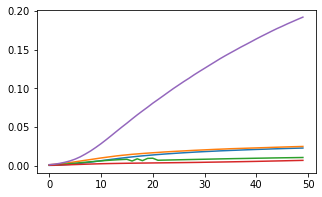

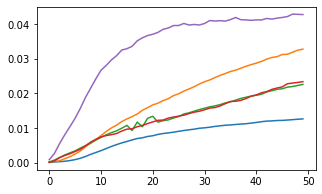

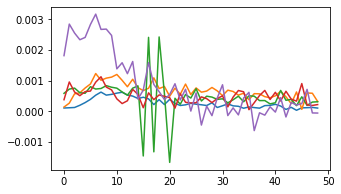

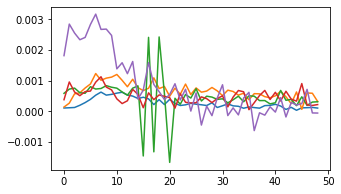

In [13]:
var_changes_L0_w, var_changes_L2_w, var_changes_L4_w, var_changes_L6_w, var_changes_L7_w = [], [], [], [], [] 
var_accumulate_L0_w, var_accumulate_L2_w, var_accumulate_L4_w, var_accumulate_L6_w, var_accumulate_L7_w = [], [], [], [], [] 

var_changes_L0_b, var_changes_L2_b, var_changes_L4_b, var_changes_L6_b, var_changes_L7_b = [], [], [], [], [] 
var_accumulate_L0_b, var_accumulate_L2_b, var_accumulate_L4_b, var_accumulate_L6_b, var_accumulate_L7_b = [], [], [], [], [] 


for global_epoch in range(G_epoch-1):
    for layer_index in num_layers_list:
        sumss_w, sumss_b = 0, 0
        for sks in range(globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch, layer_index)]):
            sumss_w = sumss_w + globals()['G{}_c{}_w_layer{}'.format(global_epoch, sks, layer_index)][0] 
            sumss_b = sumss_b + globals()['G{}_c{}_w_layer{}'.format(global_epoch, sks, layer_index)][1]

        sumss_w = sumss_w/globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch, layer_index)]
        sumss_b = sumss_b/globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch, layer_index)]

        globals()['var_accumulate_L{}_w'.format(layer_index)].append(np.var( sumss_w ))
        
        globals()['var_accumulate_L{}_b'.format(layer_index)].append(np.var( sumss_b ))
        
        

for layer_index in num_layers_list:
    for tmp_int in range(len(globals()['var_accumulate_L{}_w'.format(layer_index)])-1):
        minus_w = globals()['var_accumulate_L{}_w'.format(layer_index)][tmp_int + 1] - globals()['var_accumulate_L{}_w'.format(layer_index)][tmp_int]
        minus_b = globals()['var_accumulate_L{}_b'.format(layer_index)][tmp_int + 1] - globals()['var_accumulate_L{}_b'.format(layer_index)][tmp_int]        
        globals()['var_changes_L{}_w'.format(layer_index)].append( minus_w )
        globals()['var_changes_L{}_b'.format(layer_index)].append( minus_b )
        

print("Variance Accumulate Layer 0,2,4,6,7\n--------------------------------------------------------------------------------------------------\n")

print("\nVar Accumulate Weight\n--------------------------------------")
for j in num_layers_list:
    print(globals()['var_accumulate_L{}_w'.format(j)])

print("\nVar Accumulate Bias\n--------------------------------------")
for j in num_layers_list:
    print(globals()['var_accumulate_L{}_b'.format(j)])

print("\n\nVariance Change Layer 0,2,4,6,7\n--------------------------------------------------------------------------------------------------\n")

print("\nVar Changes Weight\n--------------------------------------")
for j in num_layers_list:
    print(globals()['var_accumulate_L{}_w'.format(j)])

print("\nVar Changes Bias\n--------------------------------------")
for j in num_layers_list:
    print(globals()['var_changes_L{}_b'.format(j)])



print("\nNow Check the graph\n")

plt.figure(figsize=(5,3))
for j in num_layers_list:
    plt.plot(globals()['var_accumulate_L{}_w'.format(j)])

plt.figure(figsize=(5,3))
for j in num_layers_list:
    plt.plot(globals()['var_accumulate_L{}_b'.format(j)])

plt.figure(figsize=(5,3))
for j in num_layers_list:
    plt.plot(globals()['var_changes_L{}_b'.format(j)])

plt.figure(figsize=(5,3))
for j in num_layers_list:
    plt.plot(globals()['var_changes_L{}_b'.format(j)])


Distance Layer 0,2,4,6,7
--------------------------------------------------------------------------------------------------
[0.020669414, 0.02496186, 0.031098949, 0.03729205, 0.043891545, 0.051078543, 0.05837657, 0.06608114, 0.07399087, 0.080861814, 0.08739174, 0.0937263, 0.09961095, 0.10494703, 0.109437115, 0.11352717, 0.11730693, 0.12106108, 0.12369968, 0.12654044, 0.12882715, 0.13139066, 0.13348295, 0.13520254, 0.13692085, 0.13871881, 0.14048162, 0.14195253, 0.14349174, 0.1451256, 0.14621, 0.14754324, 0.1488415, 0.15008672, 0.15109514, 0.15196532, 0.15287548, 0.15375726, 0.15453589, 0.15560903, 0.1564708, 0.15756398, 0.15835181, 0.15904611, 0.1597412, 0.1602625, 0.16096565, 0.16158634, 0.16224211, 0.16278268]
[0.03289616, 0.04048995, 0.048241142, 0.057819016, 0.06607442, 0.075667575, 0.08455141, 0.09407225, 0.101636015, 0.10928597, 0.116070956, 0.12267346, 0.12820889, 0.13307318, 0.13808353, 0.14174207, 0.14518939, 0.14839911, 0.15251273, 0.15513478, 0.15815297, 0.16000098, 0.162855

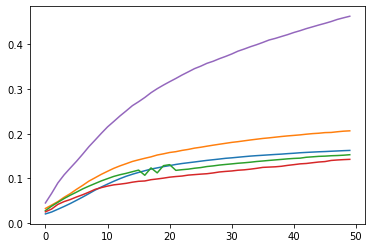

In [14]:
from scipy.spatial import distance

dist_0, dist_2, dist_4, dist_6, dist_7  = [], [], [], [], []

for global_epoch in range(G_epoch): #1이 맞음 = 바꾸지 말기
    for layer_index in num_layers_list:
        globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = 0    


for global_epoch in range(G_epoch-1):    #2가 맞음 = 바꾸지 말기
    for layer_index in num_layers_list:
        var_w = 0
        for sks in range(globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch, layer_index)]):
            var_w = var_w + globals()['G{}_c{}_w_layer{}'.format(global_epoch, sks, layer_index)]

        var_w = var_w/globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch, layer_index)]

        globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = var_w
        globals()['dist_{}'.format(layer_index)].append(np.mean(distance.euclidean(globals()['G{}_w_layer{}'.format(global_epoch, layer_index)], globals()['G{}_w_layer{}'.format(global_epoch+1, layer_index)])))

print("Distance Layer 0,2,4,6,7\n--------------------------------------------------------------------------------------------------")
print(dist_0)
print(dist_2)
print(dist_4)
print(dist_6)
print(dist_7, "\n\nCheck the graph\n")

plt.plot(dist_0)
plt.plot(dist_2)
plt.plot(dist_4)
plt.plot(dist_6)
plt.plot(dist_7)

plt.show()

[[0.5059999823570251, 0.5019999742507935, 0.42800000309944153, 0.4519999921321869, 0.49399998784065247, 0.4300000071525574, 0.4740000069141388, 0.4339999854564667, 0.44200000166893005, 0.49799999594688416, 0.44999998807907104, 0.44200000166893005, 0.4519999921321869, 0.4860000014305115, 0.4320000112056732, 0.4959999918937683, 0.4560000002384186, 0.42399999499320984, 0.4339999854564667, 0.4259999990463257], [0.37400001287460327, 0.3059999942779541, 0.3919999897480011, 0.421999990940094, 0.3659999966621399, 0.4560000002384186, 0.3580000102519989, 0.37400001287460327, 0.3959999978542328, 0.3659999966621399, 0.3779999911785126, 0.38999998569488525, 0.35600000619888306, 0.3240000009536743, 0.3479999899864197, 0.3720000088214874, 0.4020000100135803, 0.3880000114440918, 0.3880000114440918, 0.3540000021457672], [0.40400001406669617, 0.3779999911785126, 0.4180000126361847, 0.3580000102519989, 0.3919999897480011, 0.47200000286102295, 0.4020000100135803, 0.421999990940094, 0.33000001311302185, 0.

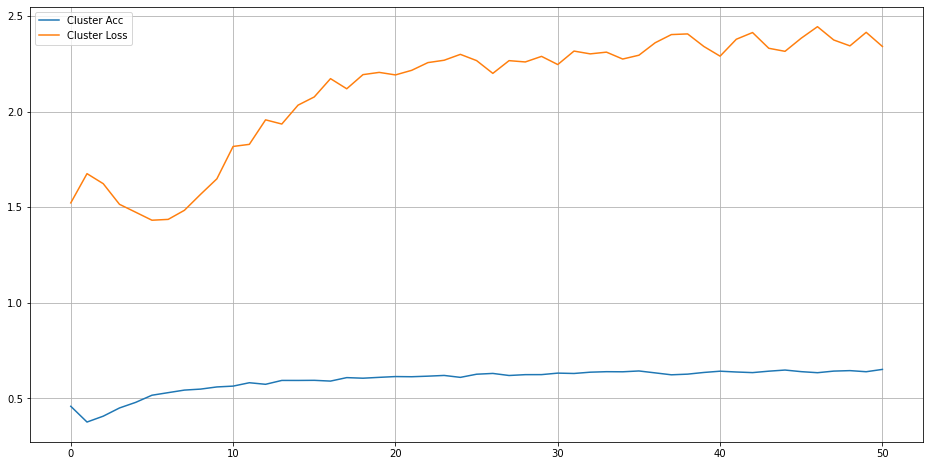

In [15]:
average_acc_cluster_list, average_loss_cluster_list = [], []


for i in range(len(Cluster_ACC)):    
    average_acc_cluster_list.append(np.mean(Cluster_ACC[i]))
    average_loss_cluster_list.append(np.mean(Cluster_LOSS[i]))

    
plt.figure(figsize=(16,8))
plt.plot(average_acc_cluster_list, label='Cluster Acc')
print(Cluster_ACC)
print(Cluster_LOSS,"\n\n\n")
plt.plot(average_loss_cluster_list, label='Cluster Loss')

plt.grid(True)
plt.legend()
plt.show()
